### Characterization of Enamel structure by 4D-STEM

- This is a series of scripts to analyze 4DSTEM data of Enamel samples acquired using K3-IS synchronized with STEMx
- Microscope: JEOL ARM300F operated at 300kV


In [1]:
%matplotlib nbagg
import py4DSTEM

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

from py4DSTEM.process.braggdiskdetection import get_average_probe_from_ROI, get_probe_kernel_subtrgaussian
from py4DSTEM.process.utils import get_CoM
from py4DSTEM.file.datastructure import DiffractionSlice, RealSlice
from py4DSTEM.file.io import read, save

**DataSet #1**

- Experimental scan dimensions: [133,131,256,256]

In [2]:
filename = 'Bin(2,2,2, 2) of outer enamel.dm4'
datacube = py4DSTEM.file.io.read(filename)

Bin(2,2,2, 2) of outer enamel.dm4 is not a py4DSTEM file.
Couldn't identify input, attempting to read with hyperspy...


In [3]:
# Setting scan shapes(need the experimental scan dimensions)
datacube.set_scan_shape(133,131)
datacube.name = 'datacube'

**Generate virtual images**

1. Create virtual masks using average diffraction

<IPython.core.display.Javascript object>


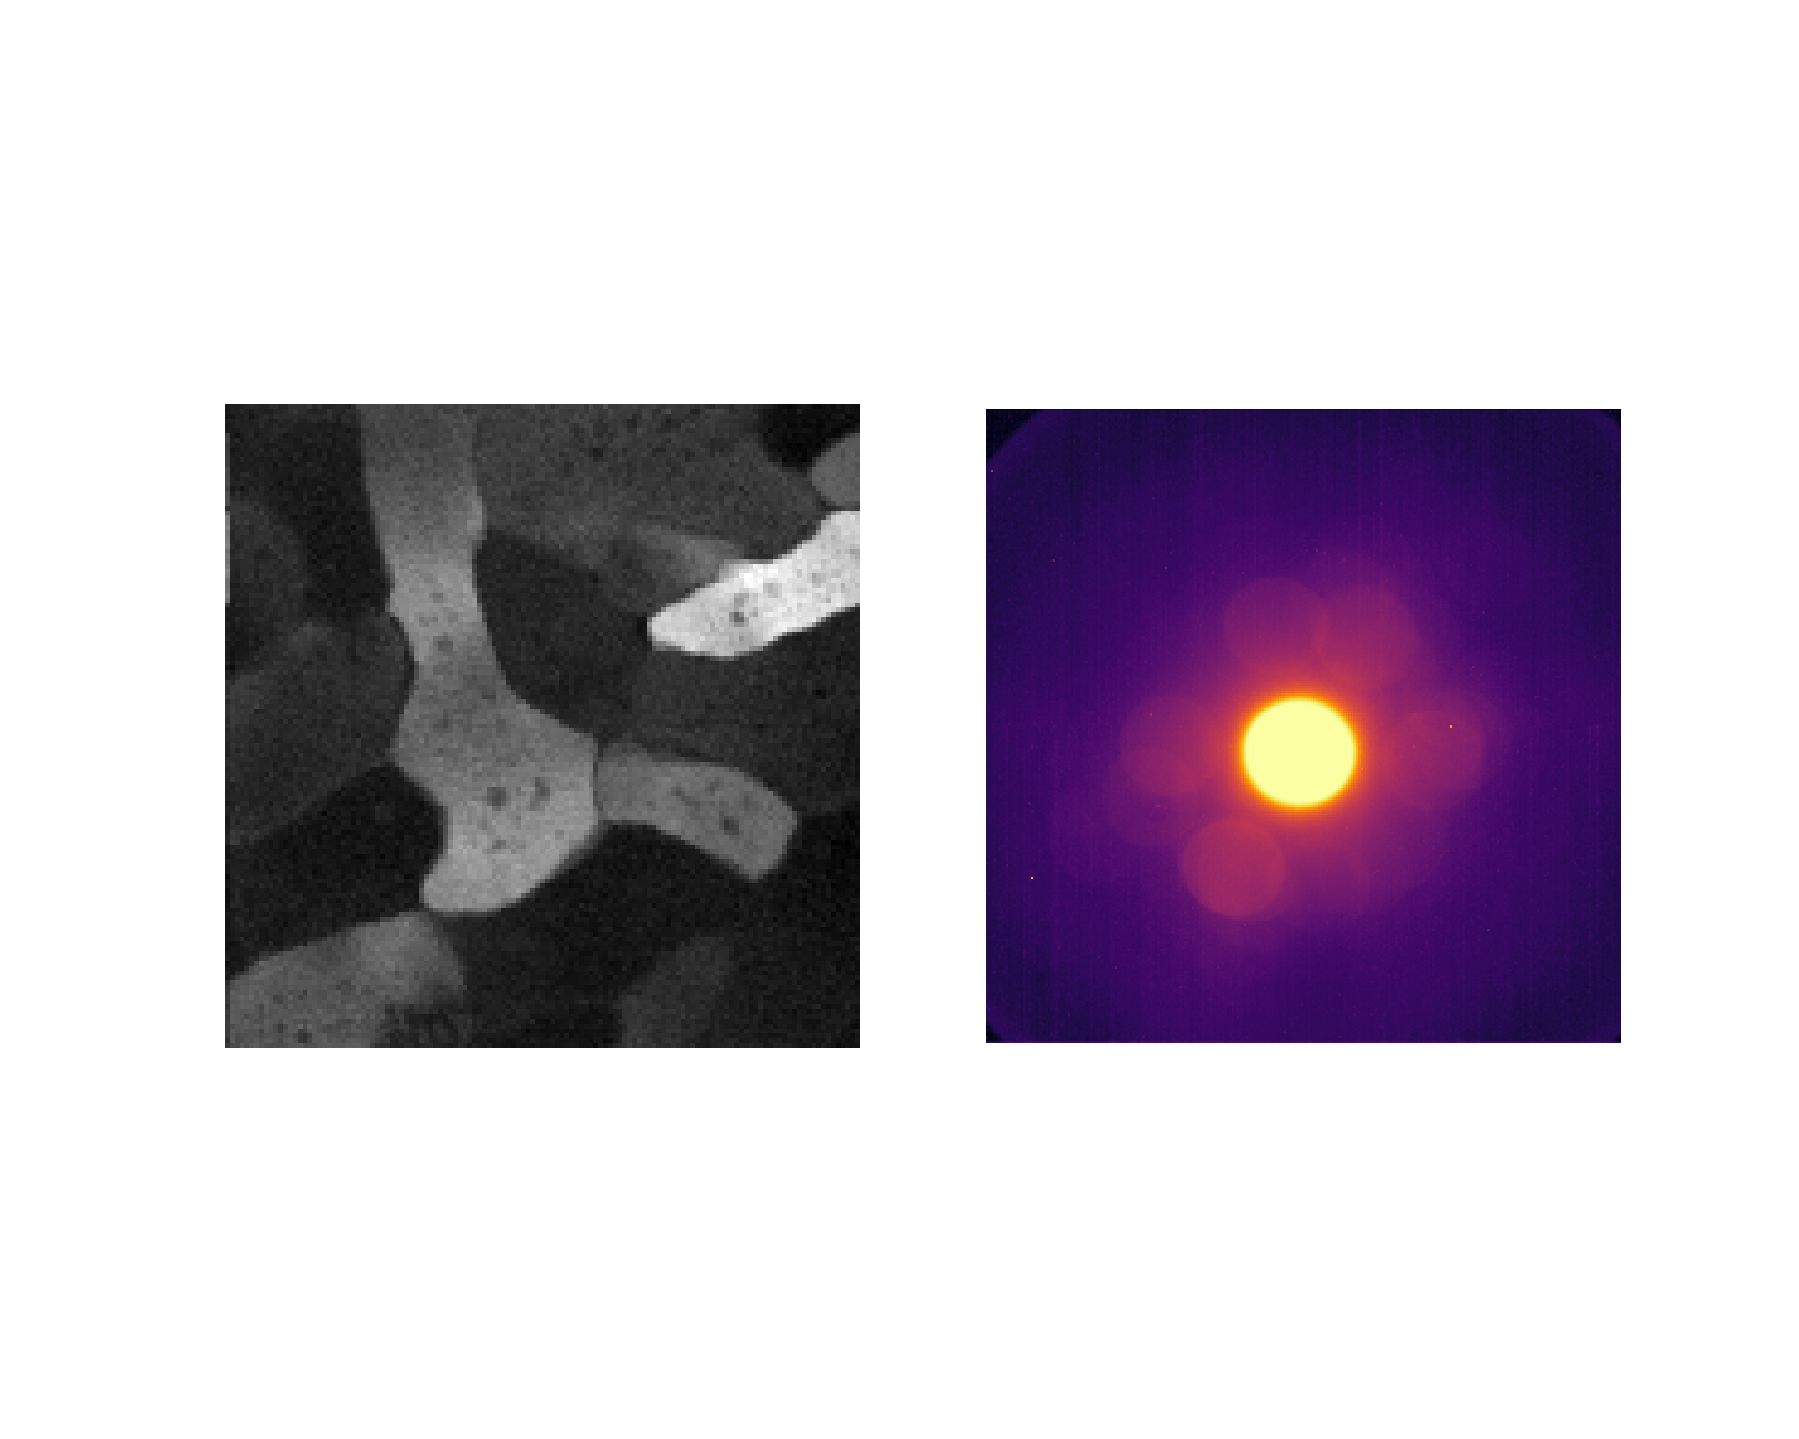

In [4]:
#take average diffraction pattern accross whole area
aveDP = np.average(datacube.data, axis=(0,1))

fig,(ax1,ax2)=plt.subplots(1,2,figsize=(10,8))

#plot real space image
ax1.matshow(np.average(datacube.data, axis=(2,3)))

#plot sqrt of average diffraciton pattern 
ax2.matshow(np.sqrt(aveDP), cmap=plt.cm.inferno)

ax1.axis('off')
ax2.axis('off')

plt.show()

In [5]:
#find center of diffraction pattern

from skued.image import powder_center
ic, jc = powder_center(aveDP)
print("ic is " + str(ic))
print("jc is " + str(jc))
#expected about (125,138) for (x,y), somehow powder center switched x and y so keep that in mind for the future  

ic is 138.5
jc is 126.0


In [6]:
#Prepare BF, ADF masks

# Make a bright field image by centering a circular virtual detector about the unscattered beam
from matplotlib.patches import Rectangle, Circle

detector_radius = 20
qx,qy = ic,jc         # Select center of virtual detector

qx0,qxf = int(qx-detector_radius),int(qx+detector_radius)
qy0,qyf = int(qy-detector_radius),int(qy+detector_radius)



BF = datacube.get_virtual_image_circ_integrate(slice(qx0,qxf),slice(qy0,qyf))[0]
# ABF =
# ADF =


<IPython.core.display.Javascript object>


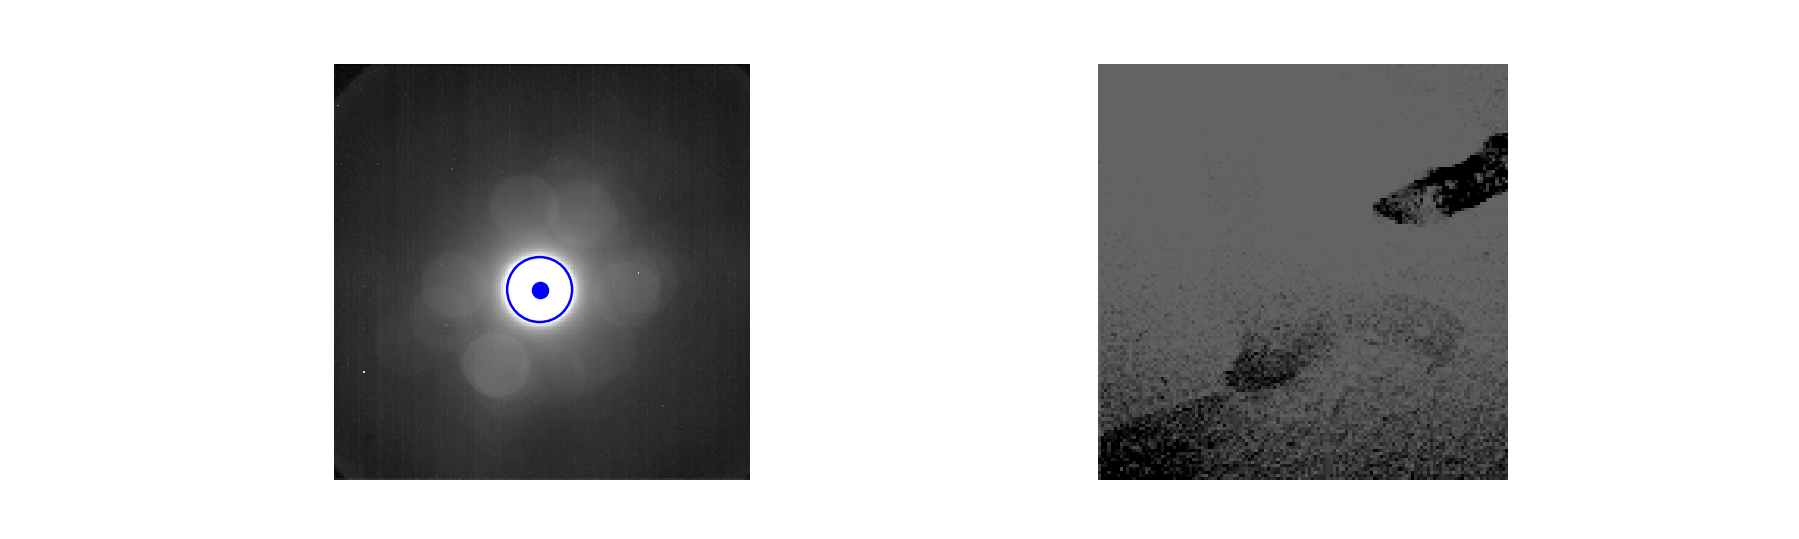

In [7]:
# Show
fig,axs = plt.subplots(1,2,figsize=(10,3))

axs[0].matshow(np.sqrt(aveDP), cmap = plt.cm.gray)
#axs[1].matshow(BF)
axs[1].matshow(np.sqrt(BF), vmin=np.sqrt(320000), vmax=np.sqrt(326000))

circ = Circle((qy,qx),detector_radius,fill=False,color='b')
axs[0].scatter(qy,qx,color='b')
axs[0].add_patch(circ)


axs[0].axis('off')
axs[1].axis('off')

plt.show()

In [8]:
#check different disks

detector_radius = 20

#x and y refer to locations from hovering over curor on matplotlib graph

qx_1,qy_1 = 186,97        # Select center of virtual detector

qx0_1,qxf_1 = int(qx_1-detector_radius),int(qx_1+detector_radius)
qy0_1,qyf_1 = int(qy_1-detector_radius),int(qy_1+detector_radius)

qx_2,qy_2 = 92,153         # Select center of virtual detector
qx0_2,qxf_2 = int(qx_2-detector_radius),int(qx_2+detector_radius)
qy0_2,qyf_2 = int(qy_2-detector_radius),int(qy_2+detector_radius)

qx_3,qy_3 = 134,74         # Select center of virtual detector
qx0_3,qxf_3 = int(qx_3-detector_radius),int(qx_3+detector_radius)
qy0_3,qyf_3 = int(qy_3-detector_radius),int(qy_3+detector_radius)


DF1 = datacube.get_virtual_image_circ_integrate(slice(qx0_1,qxf_1),slice(qy0_1,qyf_1))[0]
DF2 = datacube.get_virtual_image_circ_integrate(slice(qx0_2,qxf_2),slice(qy0_2,qyf_2))[0]
DF3 = datacube.get_virtual_image_circ_integrate(slice(qx0_3,qxf_3),slice(qy0_3,qyf_3))[0]

# ABF =
# ADF =

<IPython.core.display.Javascript object>


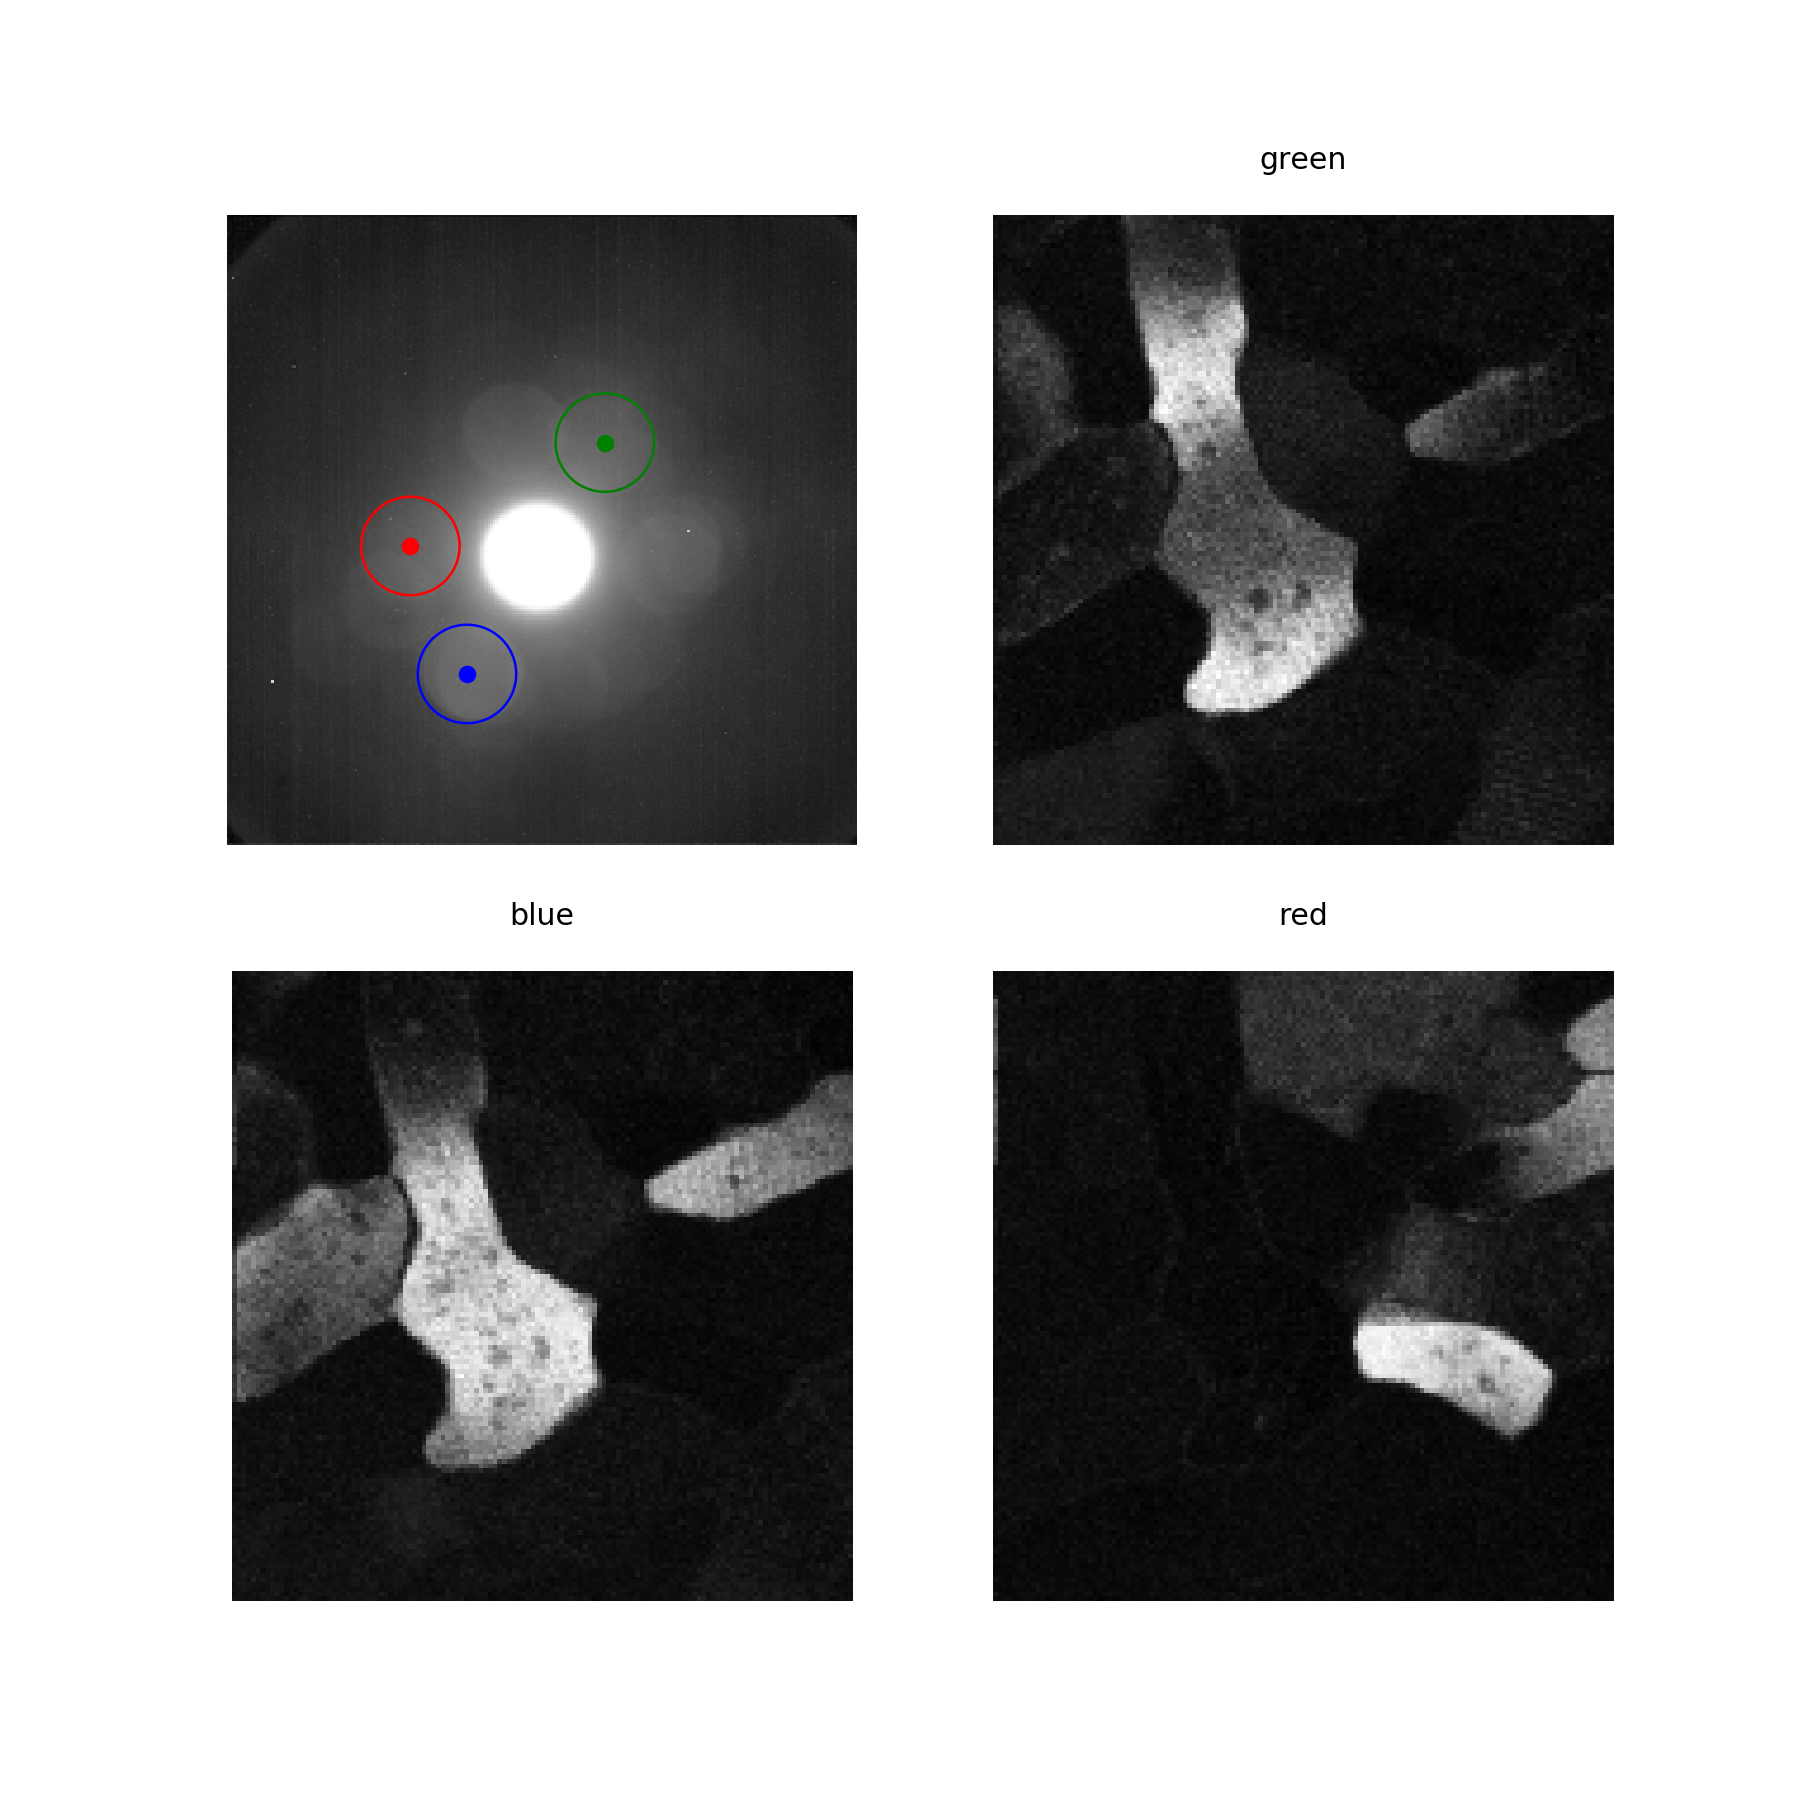

In [9]:

fig,axs = plt.subplots(2, 2, figsize=(10,10))

axs[0,0].matshow(np.sqrt(aveDP), cmap = plt.cm.gray)

circ1 = Circle((qy_1,qx_1),detector_radius,fill=False,color='b')
axs[0,0].scatter(qy_1,qx_1,color='b')
axs[0,0].add_patch(circ1)

circ2 = Circle((qy_2,qx_2),detector_radius,fill=False,color='g')
axs[0,0].scatter(qy_2,qx_2,color='g')
axs[0,0].add_patch(circ2)

circ3 = Circle((qy_3,qx_3),detector_radius,fill=False,color='r')
axs[0,0].scatter(qy_3,qx_3,color='r')
axs[0,0].add_patch(circ3)

axs[1,0].matshow(DF1)
axs[0,1].matshow(DF2)
axs[1,1].matshow(DF3)

axs[1,0].set_title('blue')
axs[0,1].set_title('green')
axs[1,1].set_title('red')

axs[0,0].axis('off')
axs[1,0].axis('off')
axs[0,1].axis('off')
axs[1,1].axis('off')


plt.show()

<IPython.core.display.Javascript object>


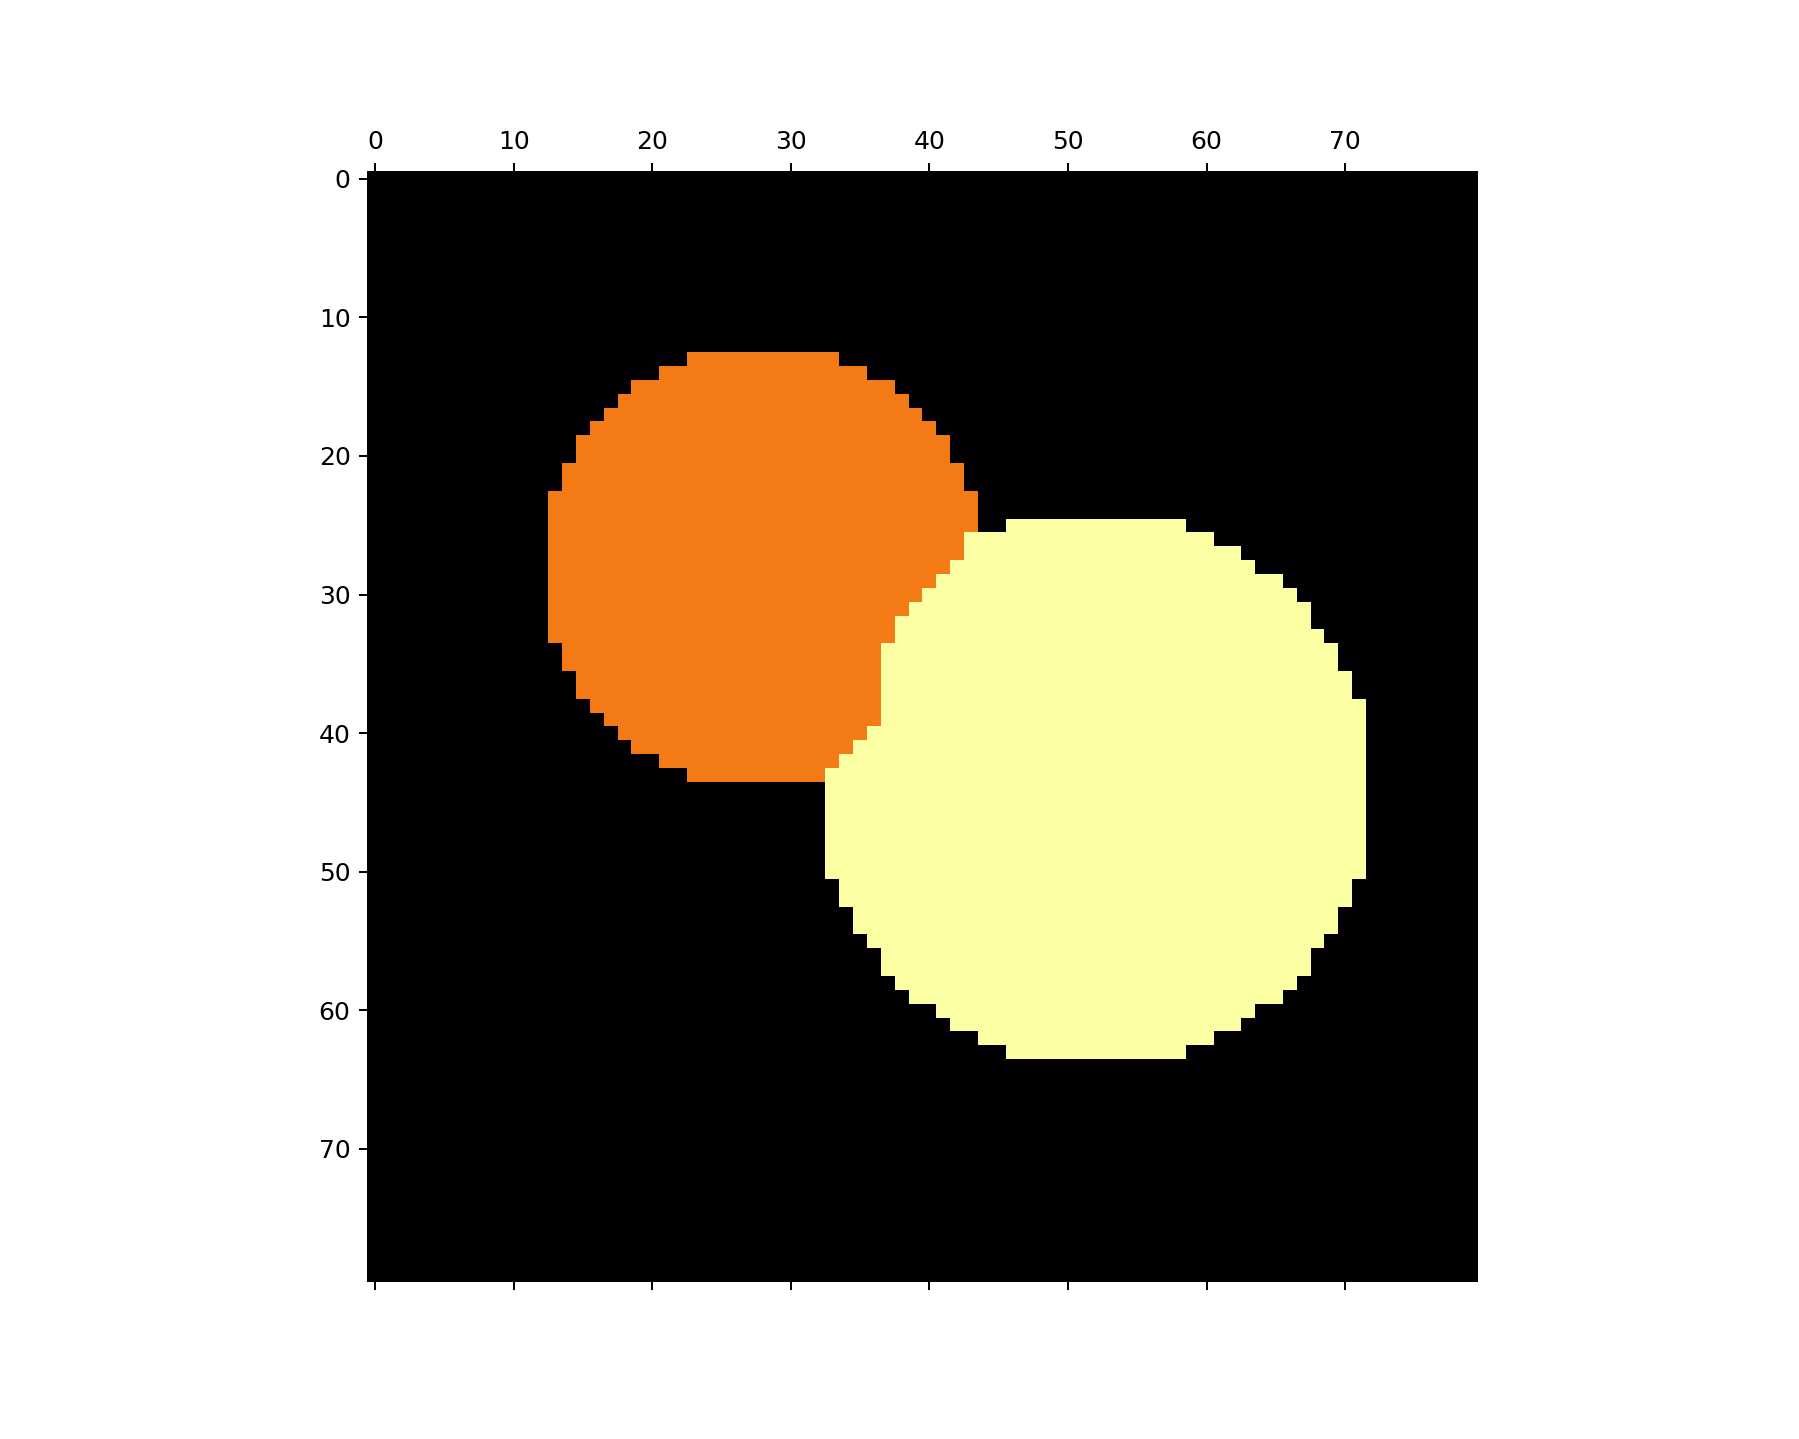

In [10]:
#Segmentation to separate disks
from skimage.morphology import watershed, label
from skimage.feature import peak_local_max

#initial image with two overlapping circles
x, y = np.indices((80, 80))
x1, y1, x2, y2 = 28, 28, 44, 52
r1, r2 = 16, 20
mask_circle1 = (x - x1) ** 2 + (y - y1) ** 2 < r1 ** 2
mask_circle2 = (x - x2) ** 2 + (y - y2) ** 2 < r2 ** 2
image = np.logical_or(mask_circle1, mask_circle2)
# Now we want to separate the two objects in image
# Generate the markers as local maxima of the distance
# to the background
from scipy import ndimage
distance = ndimage.distance_transform_edt(image)
local_maxi = peak_local_max(distance, indices=False, footprint=np.ones((3, 3)), labels=image)
markers = label(local_maxi)
labels_ws = watershed(-distance, markers, mask=image)

fig,ax=plt.subplots(figsize=(10,8))
ax.matshow(np.sqrt(labels_ws), cmap=plt.cm.inferno)
plt.show()

In [11]:
aveDP = np.average(datacube.data, axis=(0,1))
#remove center (if make it bigger than the allowed radius for the hough search then it won't find the center)
aveDP[aveDP > 150] = 0
#invert color (doesnt seem to help search but easier for me to see)
aveDP=255-aveDP

<IPython.core.display.Javascript object>


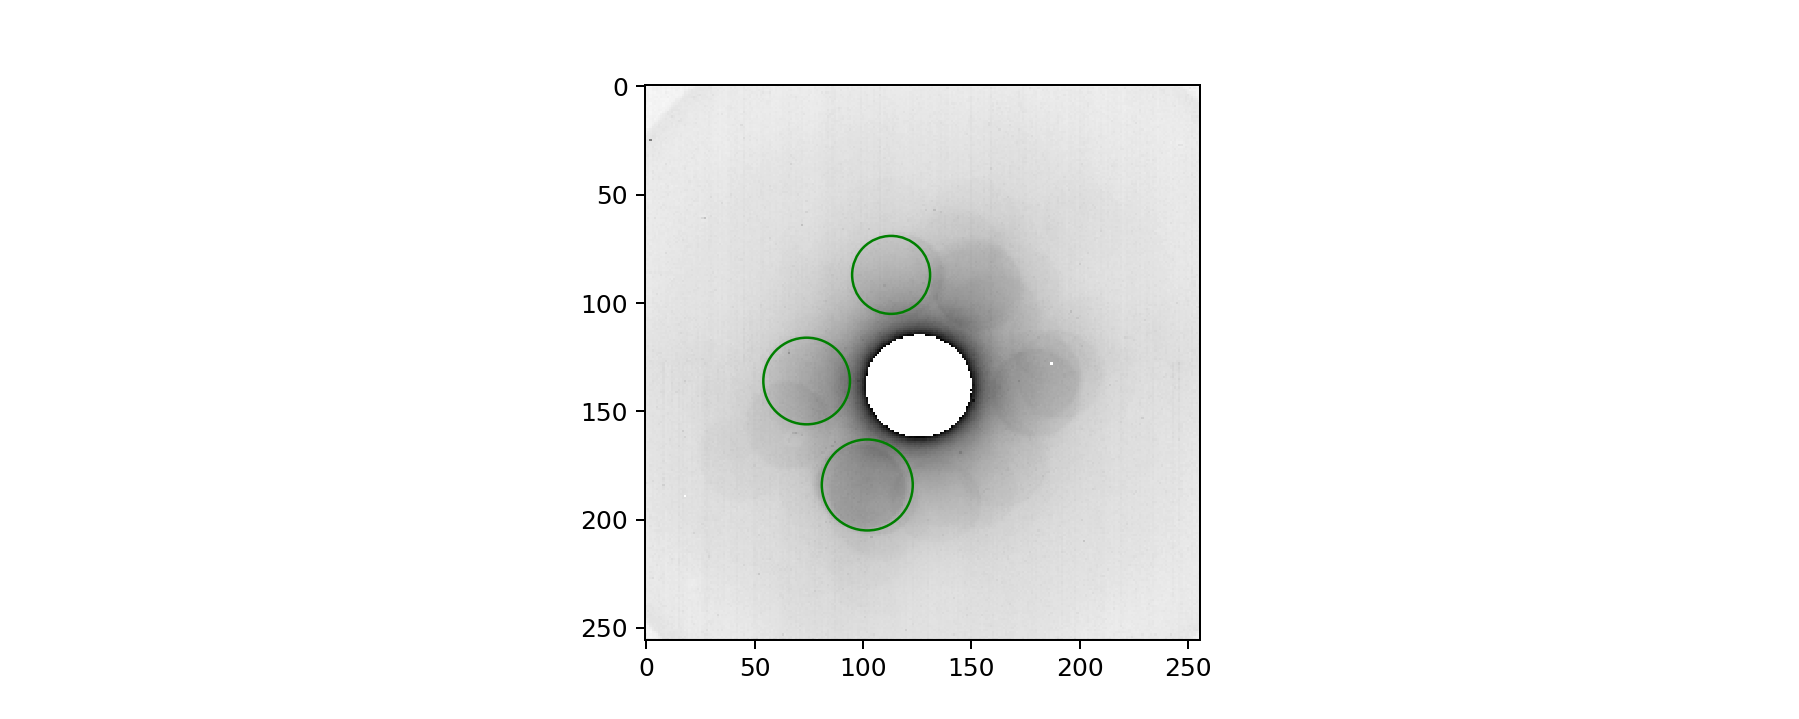

In [12]:
from skimage import data, color
from skimage.transform import hough_circle, hough_circle_peaks
from skimage.feature import canny
from skimage.draw import circle_perimeter

# Load picture and detect edges


image = aveDP
#edges = canny(image, sigma=0.5, high_threshold=5, low_threshold=3.4)
edges = canny(image, sigma=3)

# Detect two radii
hough_radii = np.arange(16, 22, 1)
hough_res = hough_circle(edges, hough_radii)

# Select the most prominent 3 circles
accums, cx, cy, radii = hough_circle_peaks(hough_res, hough_radii,
                                           total_num_peaks=3, min_xdistance=20, min_ydistance=20)
        #note: can use total_num_peaks to change the total number of peaks 

# Draw them
fig, ax = plt.subplots(figsize=(10, 4))
for center_y, center_x, radius in zip(cy, cx, radii):
    circ = Circle((center_x,center_y),radius,fill=False,color='g')
    ax.add_patch(circ)
ax.imshow(image, cmap=plt.cm.gray)
plt.show()


<IPython.core.display.Javascript object>


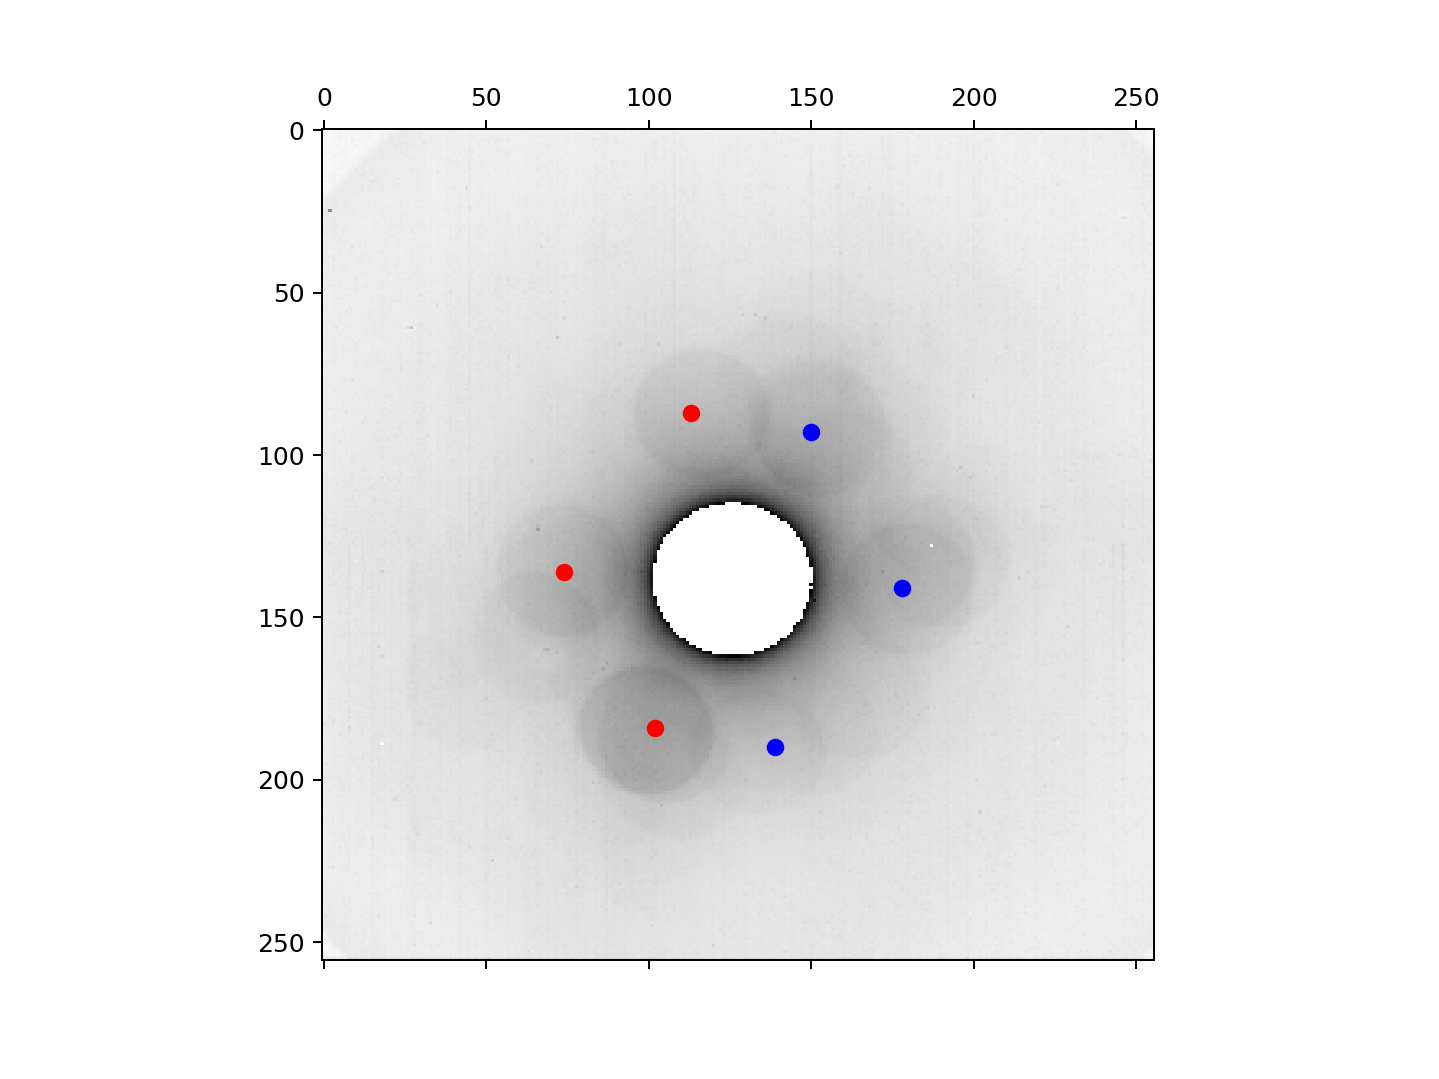

[ 74 113 102]
[178. 139. 150.]


In [13]:
cx_2=-cx+jc*2
cy_2=-cy+ic*2
fig,ax = plt.subplots(figsize=(8,6))

ax.matshow(np.sqrt(aveDP), cmap = plt.cm.gray)
ax.scatter(cx_2,cy_2, color='b')
ax.scatter(cx,cy, color='r')
plt.show()

print(cx)
print(cx_2)

<IPython.core.display.Javascript object>


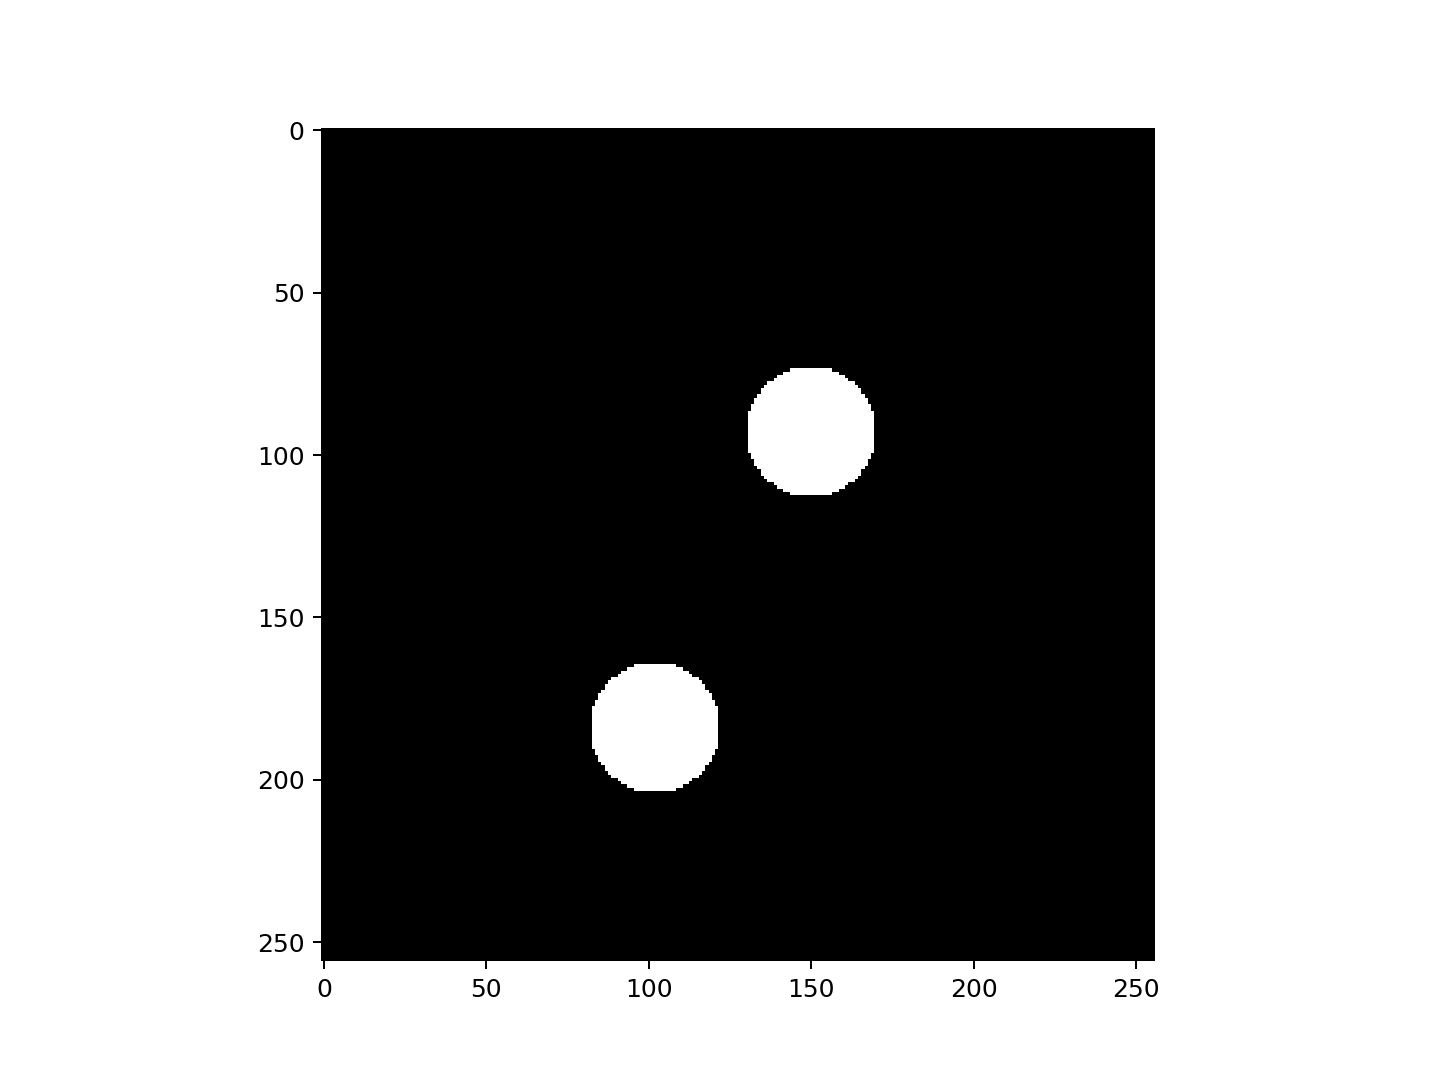

In [14]:
#create a mask for a pair of disks, a pair are diametrically opposed disks 
x, y = np.indices((aveDP.shape[0], aveDP.shape[1]))
mask_circle1 = (x - cy[2]) ** 2 + (y- cx[2]) ** 2 < 20 ** 2
mask_circle2 = (x - cy_2[2]) ** 2 + (y - cx_2[2]) ** 2 < 20 ** 2
combine_mask = np.logical_or(mask_circle1, mask_circle2)

fig,ax = plt.subplots(figsize=(8,6))
ax.imshow(combine_mask)
plt.show()

In [15]:
#extract relevant real space data using mask
DF_real_space=np.zeros((datacube.data.shape[0],datacube.data.shape[1]))

for i in range(0,aveDP.shape[0]-1):
    for j in range(0,aveDP.shape[1]-1): 
        if combine_mask[i,j]: 
            DF_real_space=DF_real_space+datacube.data[:,:,i,j] 

<IPython.core.display.Javascript object>


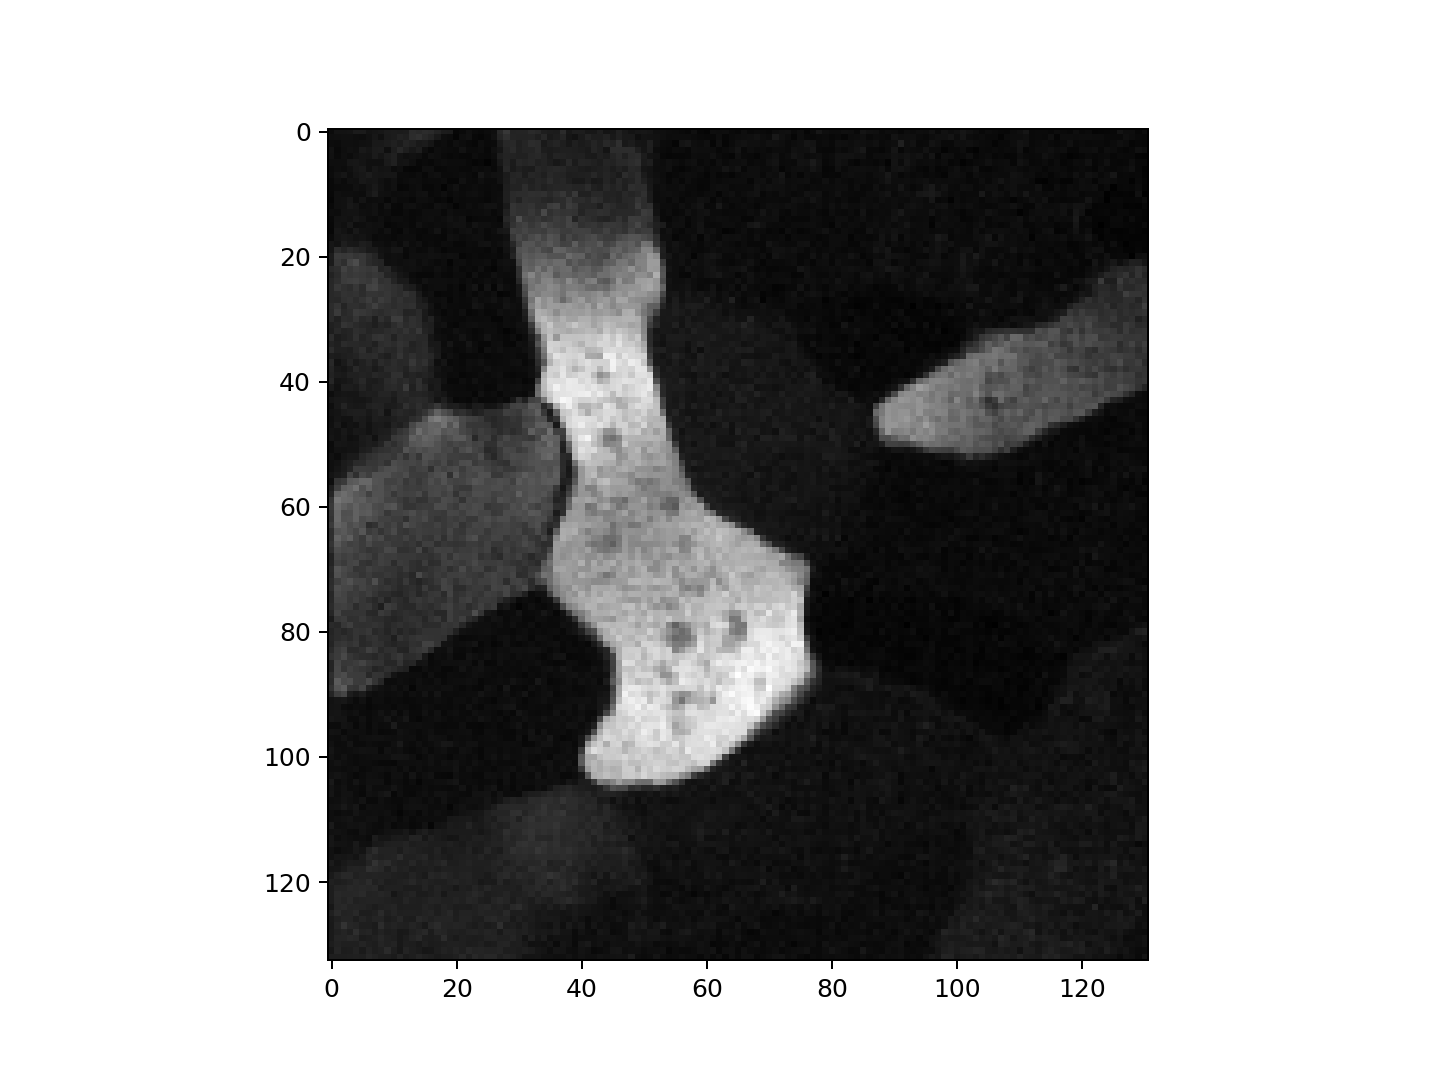

In [16]:
#plot real space grain map
fig,ax = plt.subplots(figsize=(8,6))
ax.imshow(DF_real_space)
plt.show()

In [17]:
#let's extract all data simultaneously 
output=[]
masks=[]
x, y = np.indices((aveDP.shape[0], aveDP.shape[1]))
for k in range(0, len(cx)):
    mask_circle1 = (x - cy[k]) ** 2 + (y - cx[k]) ** 2 < 20 ** 2
    mask_circle2 = (x - cy_2[k]) ** 2 + (y - cx_2[k]) ** 2 < 20 ** 2
    combine_mask = np.logical_or(mask_circle1, mask_circle2)
    masks.append(combine_mask)
    DF_real_space=np.zeros((datacube.data.shape[0],datacube.data.shape[1]))

    for i in range(0,aveDP.shape[0]):
        for j in range(0,aveDP.shape[1]): 
            if combine_mask[i,j]: 
                DF_real_space=DF_real_space+datacube.data[:,:,i,j] 
    output.append(DF_real_space)

<IPython.core.display.Javascript object>


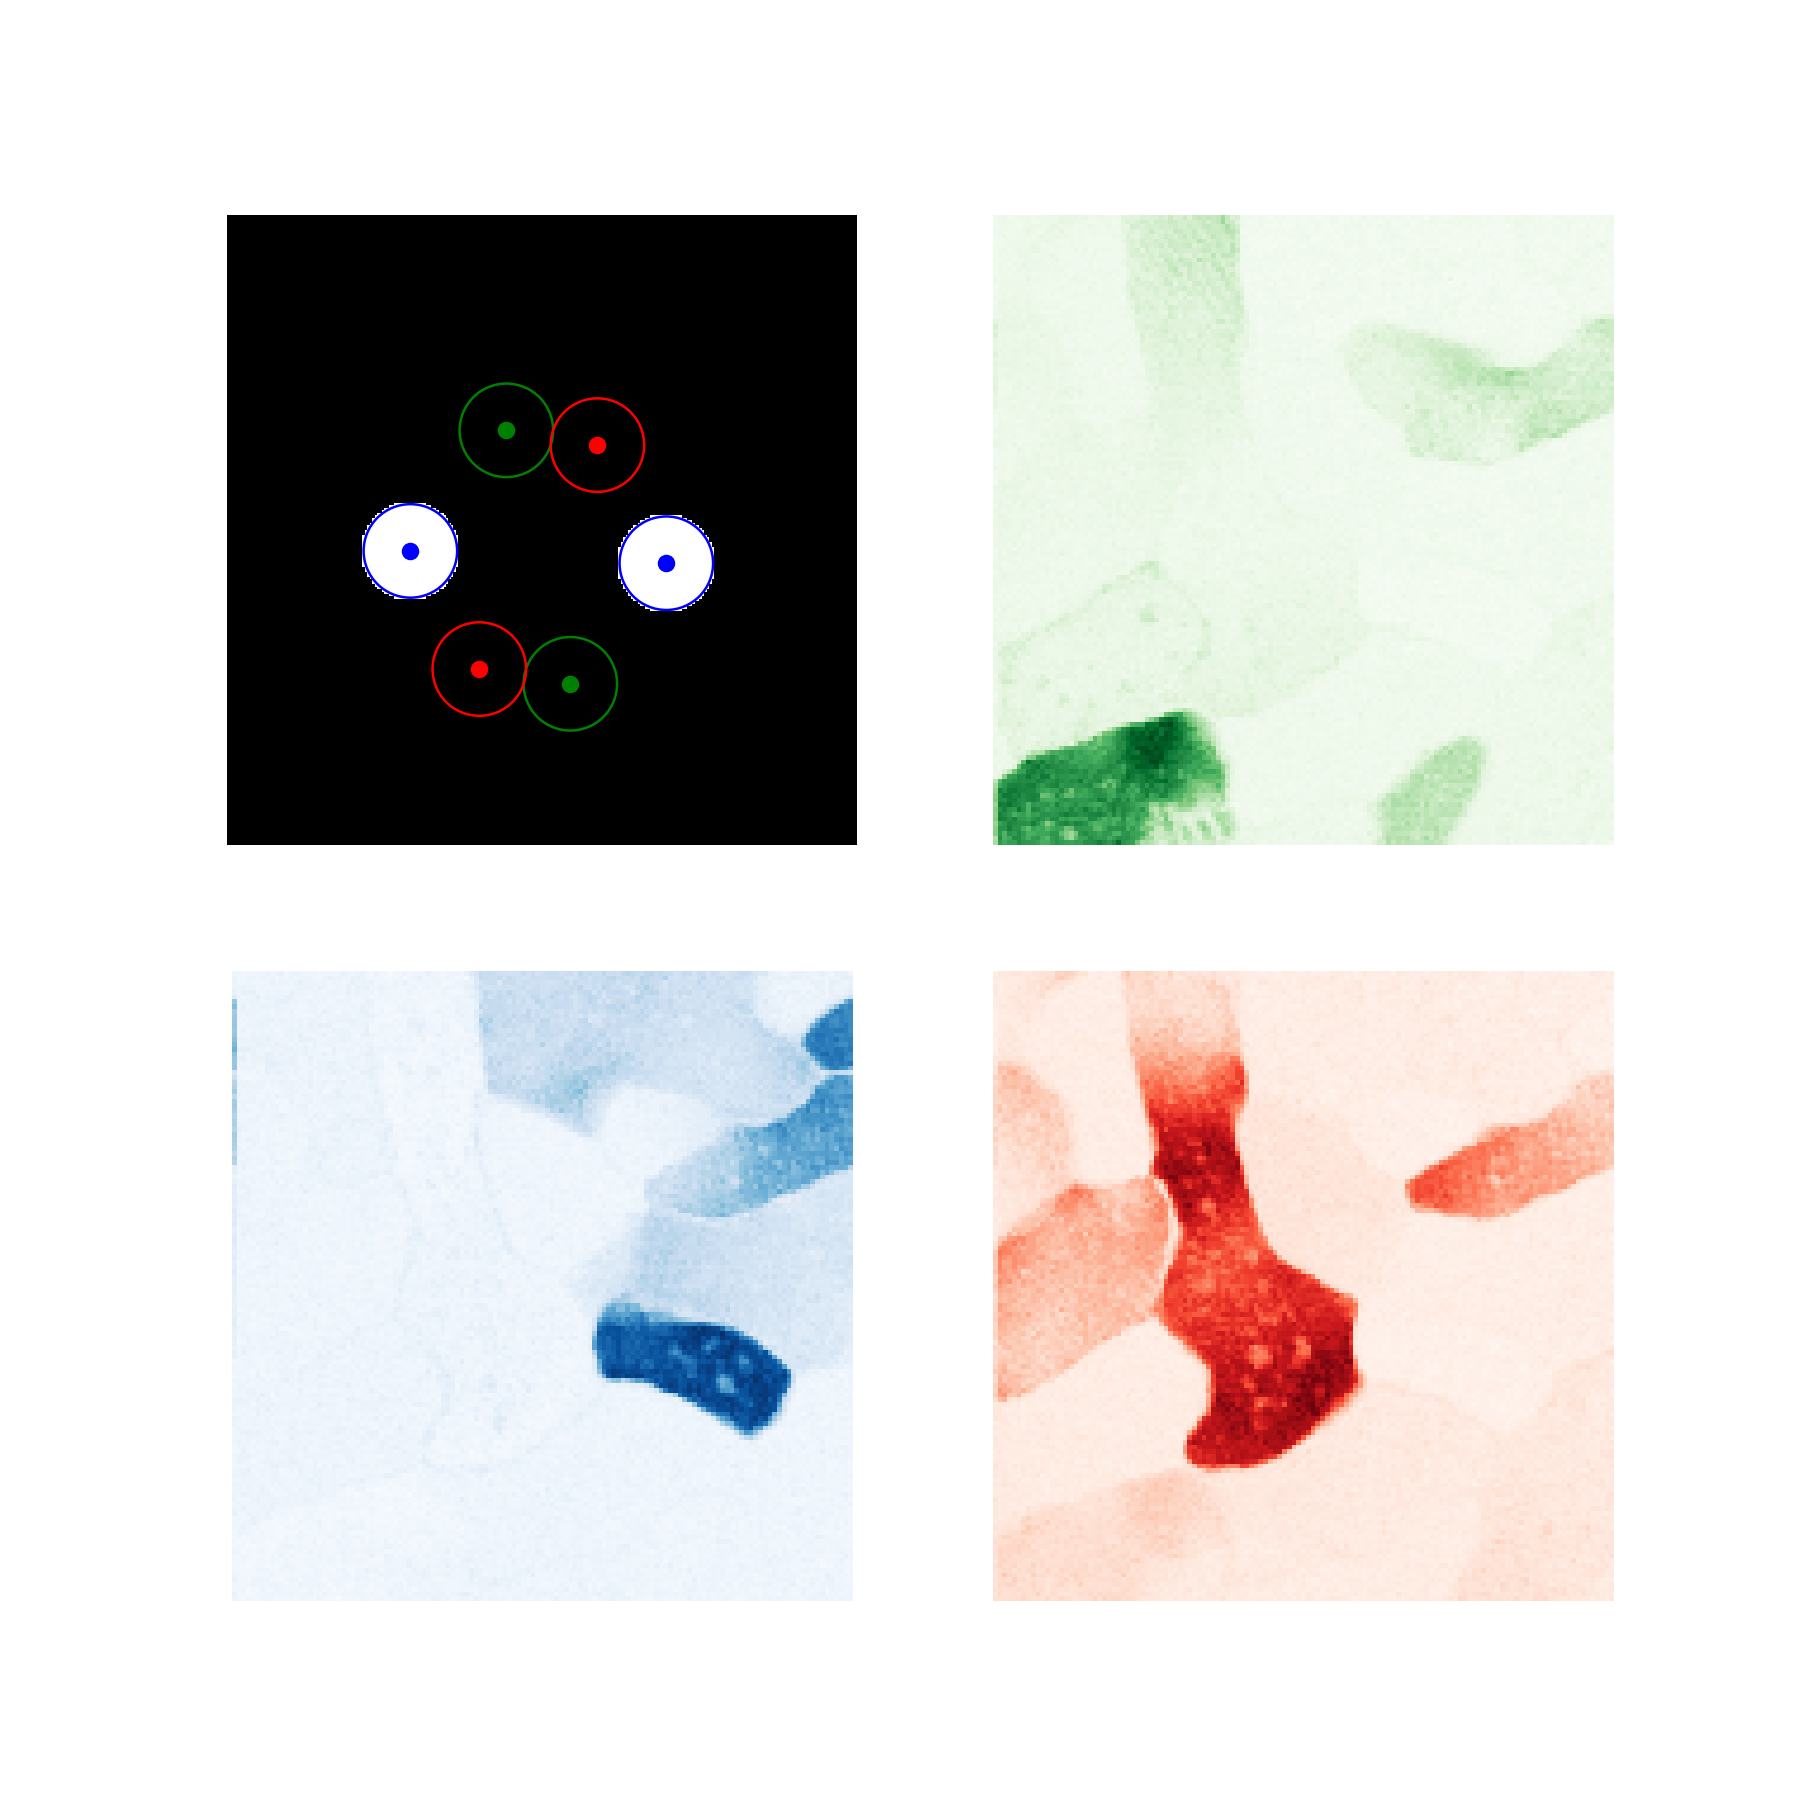

In [18]:
aveDP = np.average(datacube.data, axis=(0,1))

fig,axs = plt.subplots(2, 2, figsize=(10,10))

axs[0,0].matshow(np.sqrt(aveDP), cmap = plt.cm.gray)

circ1 = Circle((cx[0],cy[0]),19,fill=False,color='b')
axs[0,0].scatter(cx[0],cy[0],color='b')
axs[0,0].add_patch(circ1)
circ1 = Circle((cx_2[0],cy_2[0]),19,fill=False,color='b')
axs[0,0].scatter(cx_2[0],cy_2[0],color='b')
axs[0,0].add_patch(circ1)
axs[0,0].matshow(masks[0]) #check zero mask aligns with blue dots

circ1 = Circle((cx[1],cy[1]),19,fill=False,color='g')
axs[0,0].scatter(cx[1],cy[1],color='g')
axs[0,0].add_patch(circ1)
circ1 = Circle((cx_2[1],cy_2[1]),19,fill=False,color='g')
axs[0,0].scatter(cx_2[1],cy_2[1],color='g')
axs[0,0].add_patch(circ1)
#axs[0,0].matshow(masks[1]) #check zero mask aligns with green dots

circ1 = Circle((cx[2],cy[2]),19,fill=False,color='r')
axs[0,0].scatter(cx[2],cy[2],color='r')
axs[0,0].add_patch(circ1)
circ1 = Circle((cx_2[2],cy_2[2]),19,fill=False,color='r')
axs[0,0].scatter(cx_2[2],cy_2[2],color='r')
axs[0,0].add_patch(circ1)
#axs[0,0].matshow(masks[2])

axs[1,0].matshow(output[0], cmap = plt.cm.Blues)
axs[0,1].matshow(output[1], cmap = plt.cm.Greens)
axs[1,1].matshow(output[2], cmap = plt.cm.Reds)

axs[0,0].axis('off')
axs[1,0].axis('off')
axs[0,1].axis('off')
axs[1,1].axis('off')


plt.show()

<IPython.core.display.Javascript object>


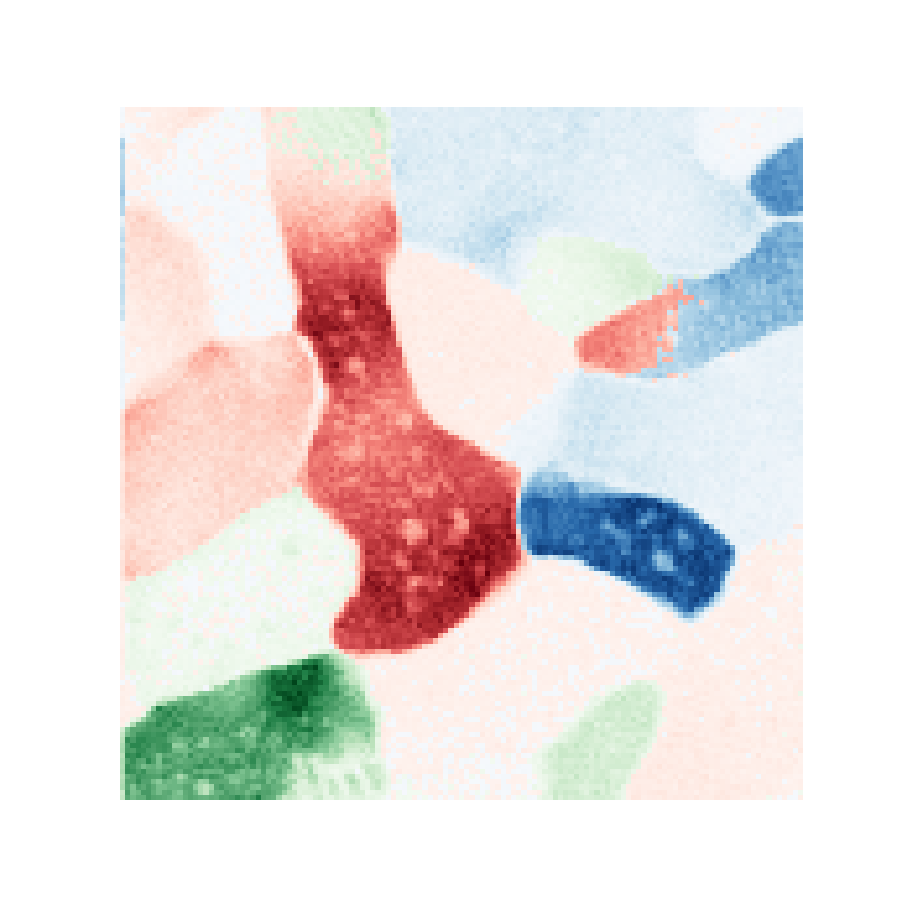

In [19]:
from matplotlib.colors import ListedColormap

for i in range(0,datacube.data.shape[0]):
        for j in range(0,datacube.data.shape[1]): 
            if output[0][i,j] >= output[1][i,j] and output[0][i,j] >= output[2][i,j]:
                output[1][i,j]=0
                output[2][i,j]=0
            if output[1][i,j] > output[0][i,j] and output[1][i,j] > output[2][i,j]:
                output[0][i,j]=0
                output[2][i,j]=0
            if output[2][i,j] > output[1][i,j] and output[2][i,j] > output[0][i,j]:
                output[0][i,j]=0
                output[1][i,j]=0


#make your own color bars with transparent instead of white as lower bound                
cmap = plt.cm.Reds
my_red = cmap(np.arange(cmap.N))
my_red[:,-1] = np.linspace(0, 1, cmap.N)
my_red = ListedColormap(my_red)

cmap = plt.cm.Greens
my_green = cmap(np.arange(cmap.N))
my_green[:,-1] = np.linspace(0, 1, cmap.N)
my_green= ListedColormap(my_green)

cmap = plt.cm.Blues
my_blue = cmap(np.arange(cmap.N))
my_blue[:,-1] = np.linspace(0, 1, cmap.N)
my_blue = ListedColormap(my_blue)


fig,axs = plt.subplots(figsize=(5,5))
axs.matshow(output[0], cmap = my_blue)
axs.matshow(output[1], cmap = my_green)
axs.matshow(output[2], cmap = my_red)

axs.axis('off')

plt.show()

In [20]:
#clear cx, cy, cx_2, cy_2
del cx, cy, cx_2, cy_2

/Users/sribet/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:29: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


<IPython.core.display.Javascript object>


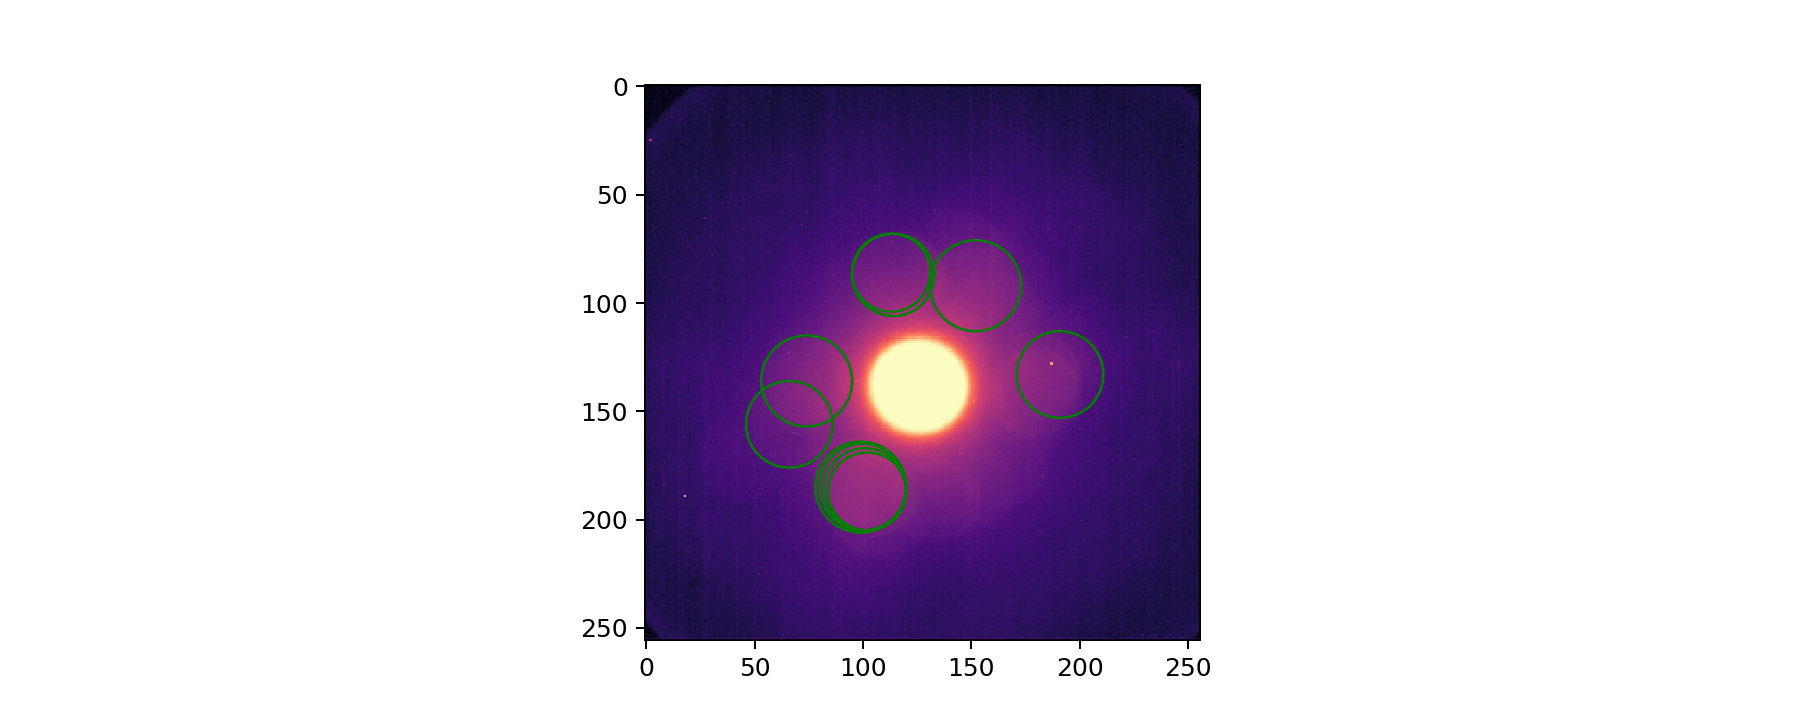

In [59]:
#let's start again using slightly different parameters for the hough transform 

#write over aveDP since we edited it for the last hough transfrom
aveDP =np.average(datacube.data, axis=(0,1))
aveDP=np.sqrt(aveDP)


from skimage import data, color
from skimage.transform import hough_circle, hough_circle_peaks
from skimage.feature import canny
from skimage.draw import circle_perimeter

# Load picture and detect edges


image = aveDP
#edges = canny(image, sigma=0.5, high_threshold=5, low_threshold=3.4)
edges = canny(image, sigma=2)

# Detect two radii
hough_radii = np.arange(18, 22, 1)
hough_res = hough_circle(edges, hough_radii)

# Select the most prominent 3 circles
accums, cx, cy, radii = hough_circle_peaks(hough_res, hough_radii,
                                           total_num_peaks=10, min_xdistance=20, min_ydistance=20)

# Draw them
fig, ax = plt.subplots(figsize=(10, 4))
for center_y, center_x, radius in zip(cy, cx, radii):
    circ = Circle((center_x,center_y),radius,fill=False,color='g')
    ax.add_patch(circ)
ax.imshow(image, cmap=plt.cm.magma)
plt.show()

In [60]:
#remove circles that are on top of eachother
p = cx.argsort()
cx=cx[p]
cy=cy[p]

#min distance can be changed
MIN_DISTANCE = 4

for i in range(len(cx)-1):
    if(cx[i+1] - cx[i] < MIN_DISTANCE):
        cx[i+1] = cx[i]
        cy[i+1] = cy[i]

        
        
_, idx = np.unique(cx, return_index=True)
cx=cx[np.sort(idx)]

_, idx = np.unique(cy, return_index=True)
cy=cy[np.sort(idx)]

#cx = np.unique(cx)
#cy = np.unique(cy)

/Users/sribet/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  after removing the cwd from sys.path.


<IPython.core.display.Javascript object>


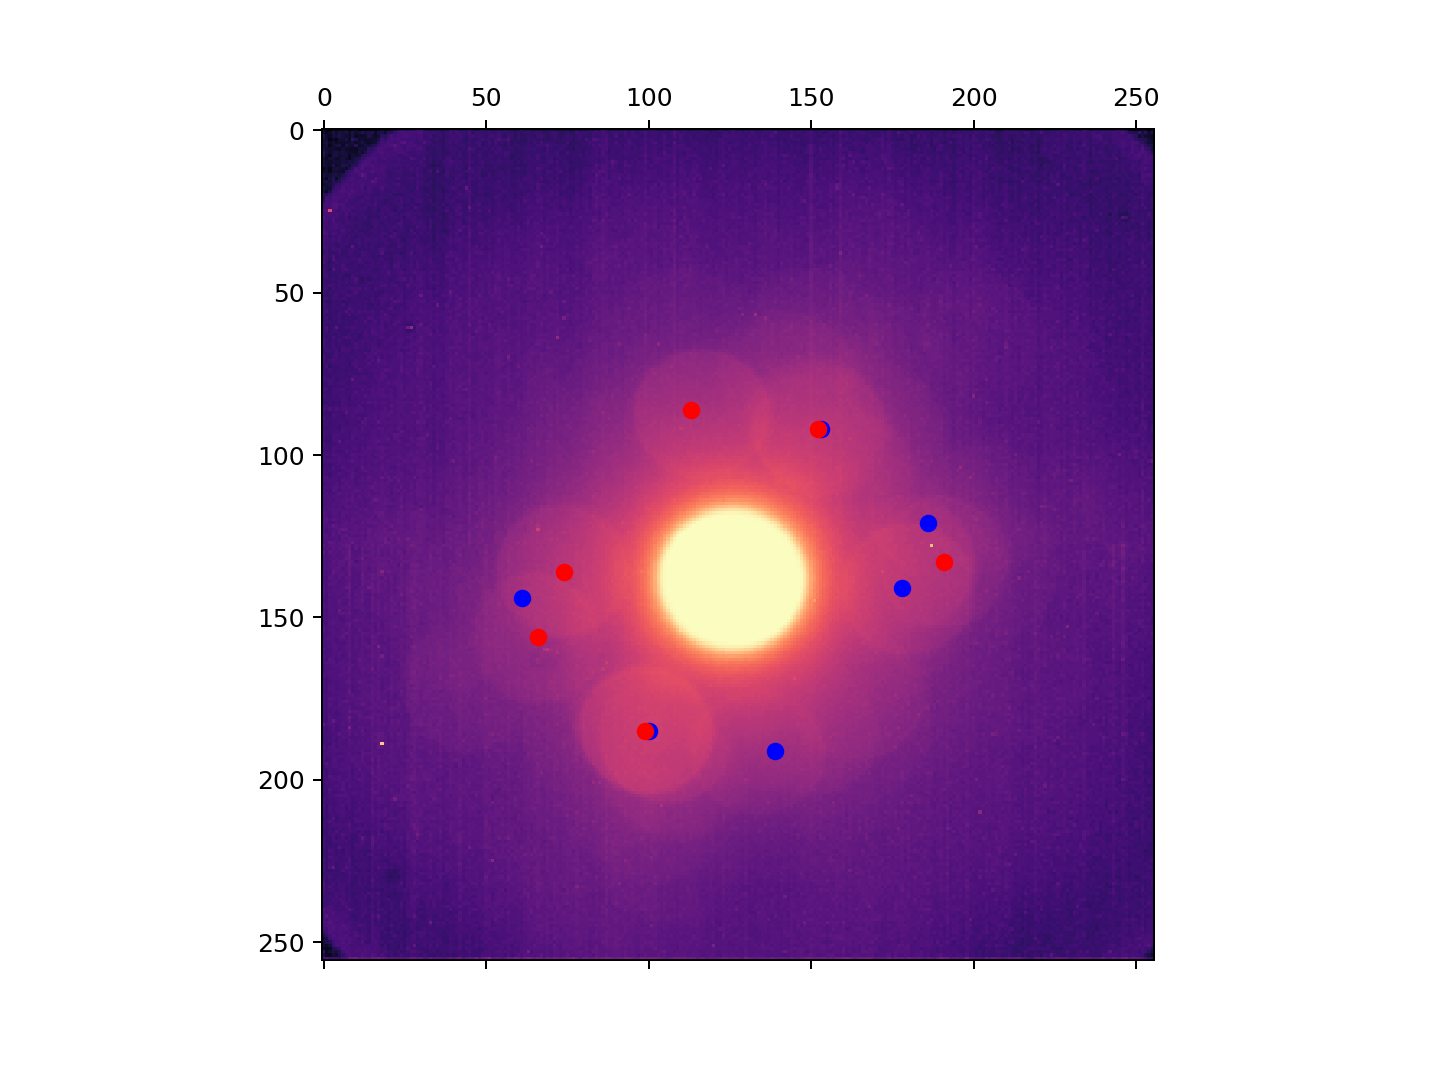

In [61]:
cx_2=-cx+jc*2
cy_2=-cy+ic*2

fig,ax = plt.subplots(figsize=(8,6))
ax.matshow(np.sqrt(aveDP), cmap = plt.cm.magma)
ax.scatter(cx_2,cy_2, color='b')
ax.scatter(cx,cy, color='r')
plt.show()

[ 66  74  99 113 152 191]
[ 66  74  99 113 191]


/Users/sribet/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  if __name__ == '__main__':


<IPython.core.display.Javascript object>


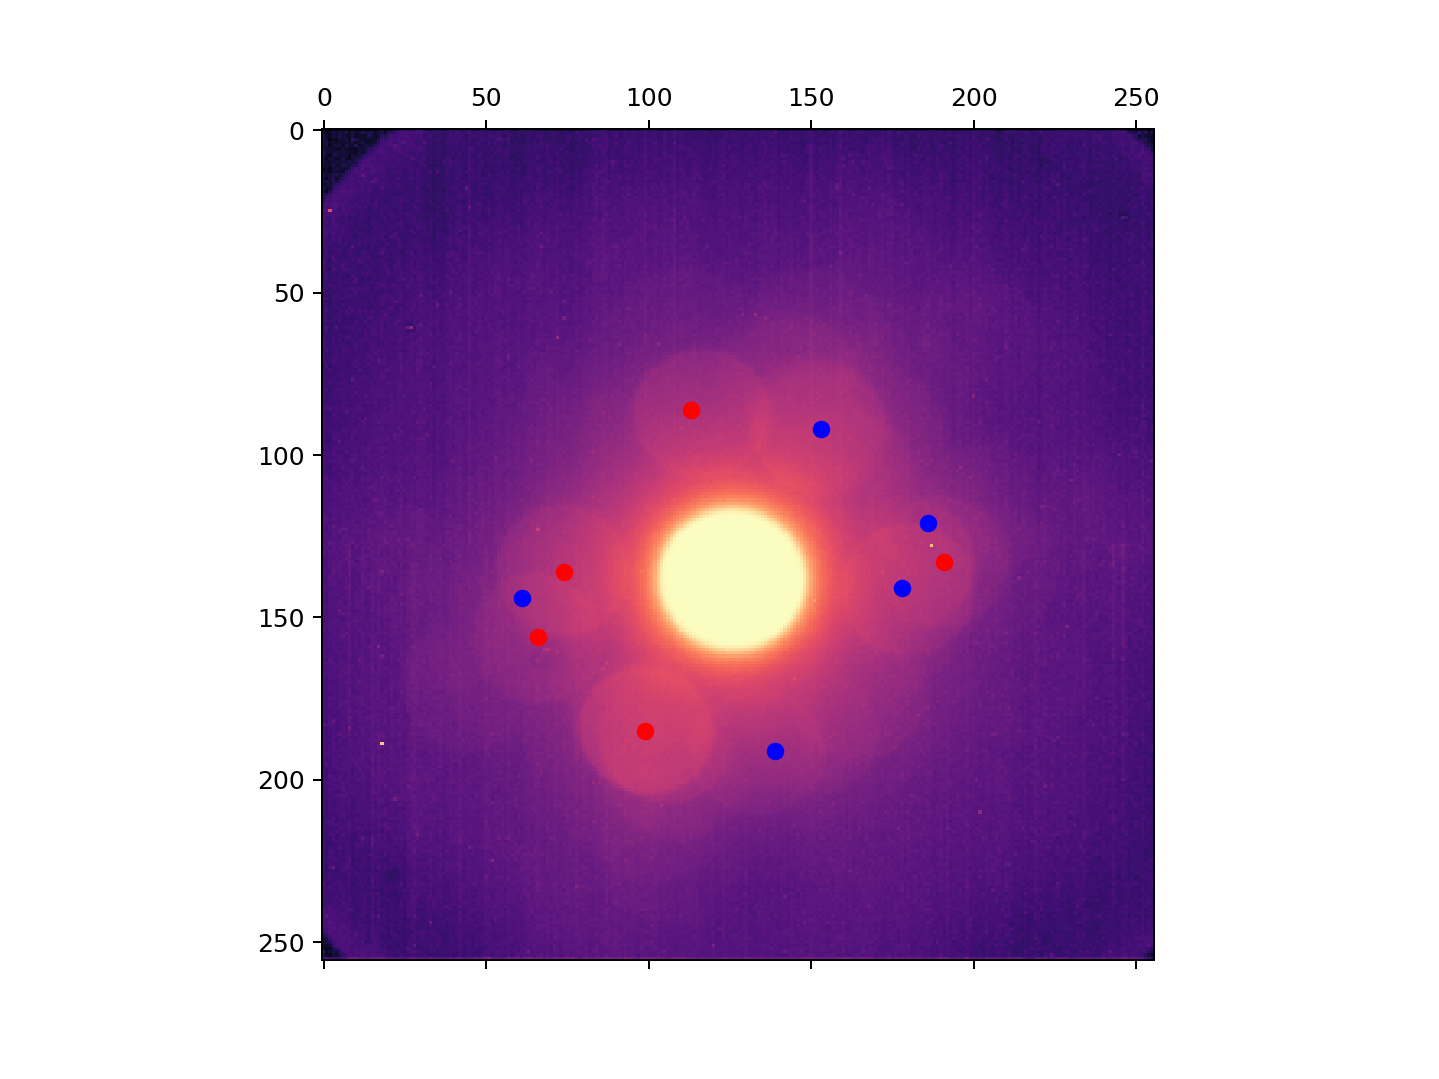

In [62]:
#let's remove the circles that are diametrically opposed 
print(cx)
cx=np.delete(cx,[4])
cy=np.delete(cy,[4])
cx_2=np.delete(cx_2,[4])
cy_2=np.delete(cy_2,[4])
print(cx)

fig,ax = plt.subplots(figsize=(8,6))
ax.matshow(np.sqrt(aveDP), cmap = plt.cm.magma)
ax.scatter(cx_2,cy_2, color='b')
ax.scatter(cx,cy, color='r')
plt.show()

In [63]:
#let's extract all data simultaneously 
output=[]
masks=[]
x, y = np.indices((aveDP.shape[0], aveDP.shape[1]))
for k in range(0, len(cx)):
    mask_circle1 = (x - cy[k]) ** 2 + (y - cx[k]) ** 2 < 20 ** 2
    mask_circle2 = (x - cy_2[k]) ** 2 + (y - cx_2[k]) ** 2 < 20 ** 2
    combine_mask = np.logical_or(mask_circle1, mask_circle2)
    masks.append(combine_mask)
    DF_real_space=np.zeros((datacube.data.shape[0],datacube.data.shape[1]))

    for i in range(0,aveDP.shape[0]):
        for j in range(0,aveDP.shape[1]): 
            if combine_mask[i,j]: 
                DF_real_space=DF_real_space+datacube.data[:,:,i,j] 
    output.append(DF_real_space)

/Users/sribet/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  This is separate from the ipykernel package so we can avoid doing imports until


<IPython.core.display.Javascript object>


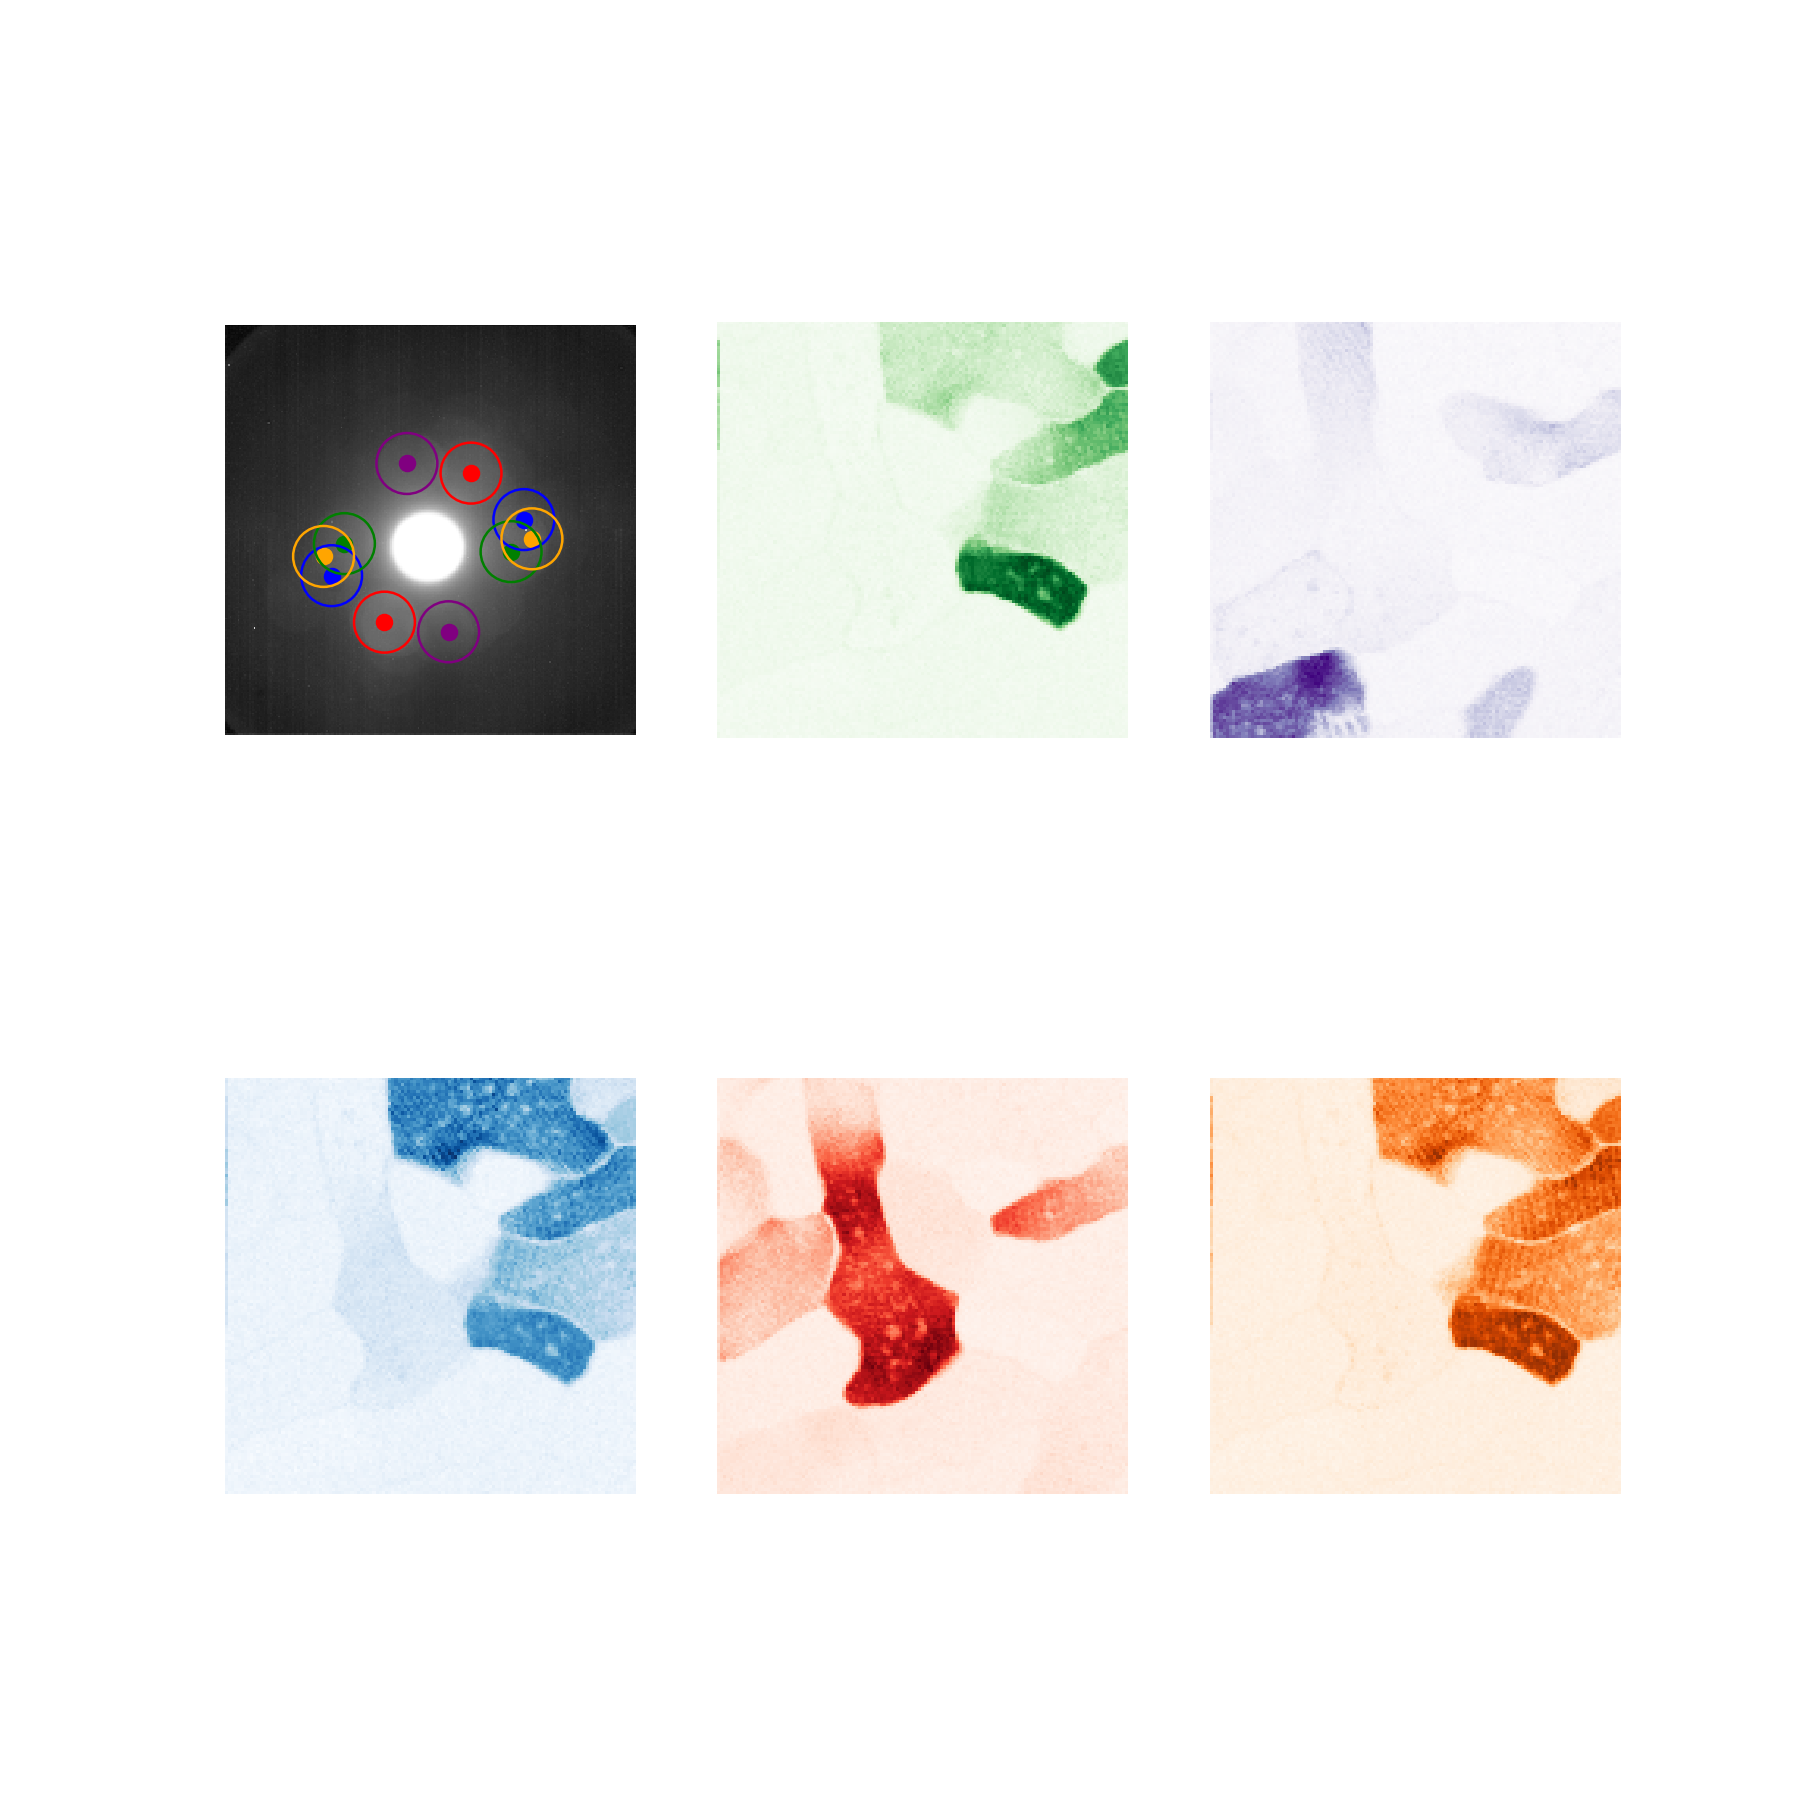

In [64]:
aveDP = np.average(datacube.data, axis=(0,1))

fig,axs = plt.subplots(2, 3, figsize=(10,10))

axs[0,0].matshow(np.sqrt(aveDP), cmap = plt.cm.gray)

circ1 = Circle((cx[0],cy[0]),19,fill=False,color='b')
axs[0,0].scatter(cx[0],cy[0],color='b')
axs[0,0].add_patch(circ1)
circ1 = Circle((cx_2[0],cy_2[0]),19,fill=False,color='b')
axs[0,0].scatter(cx_2[0],cy_2[0],color='b')
axs[0,0].add_patch(circ1)
#axs[0,0].matshow(masks[2]) #for checking mask alignment 

circ1 = Circle((cx[1],cy[1]),19,fill=False,color='g')
axs[0,0].scatter(cx[1],cy[1],color='g')
axs[0,0].add_patch(circ1)
circ1 = Circle((cx_2[1],cy_2[1]),19,fill=False,color='g')
axs[0,0].scatter(cx_2[1],cy_2[1],color='g')
axs[0,0].add_patch(circ1)

circ1 = Circle((cx[2],cy[2]),19,fill=False,color='r')
axs[0,0].scatter(cx[2],cy[2],color='r')
axs[0,0].add_patch(circ1)
circ1 = Circle((cx_2[2],cy_2[2]),19,fill=False,color='r')
axs[0,0].scatter(cx_2[2],cy_2[2],color='r')
axs[0,0].add_patch(circ1)


circ1 = Circle((cx[3],cy[3]),19,fill=False,color='purple')
axs[0,0].scatter(cx[3],cy[3],color='purple')
axs[0,0].add_patch(circ1)
circ1 = Circle((cx_2[3],cy_2[3]),19,fill=False,color='purple')
axs[0,0].scatter(cx_2[3],cy_2[3],color='purple')
axs[0,0].add_patch(circ1)


circ1 = Circle((cx[4],cy[4]),19,fill=False,color='orange')
axs[0,0].scatter(cx[4],cy[4],color='orange')
axs[0,0].add_patch(circ1)
circ1 = Circle((cx_2[4],cy_2[4]),19,fill=False,color='orange')
axs[0,0].scatter(cx_2[4],cy_2[4],color='orange')
axs[0,0].add_patch(circ1)

#circ1 = Circle((cx[5],cy[5]),19,fill=False,color='yellow')
#axs[0,0].scatter(cx[5],cy[5],color='yellow')
#axs[0,0].add_patch(circ1)
#circ1 = Circle((cx_2[5],cy_2[5]),19,fill=False,color='yellow')
#axs[0,0].scatter(cx_2[5],cy_2[5],color='yellow')
#axs[0,0].add_patch(circ1)

axs[1,0].matshow(output[0], cmap = plt.cm.Blues)
axs[0,1].matshow(output[1], cmap = plt.cm.Greens)
axs[1,1].matshow(output[2], cmap = plt.cm.Reds)
axs[0,2].matshow(output[3], cmap = plt.cm.Purples)
axs[1,2].matshow(output[4], cmap = plt.cm.Oranges)
#axs[2,0].matshow(output[5], cmap = plt.cm.YlOrRd)


axs[0,0].axis('off')
axs[1,0].axis('off')
axs[0,1].axis('off')
axs[1,1].axis('off')
axs[0,2].axis('off')
axs[1,2].axis('off')
#axs[2,0].axis('off')


plt.show()

<IPython.core.display.Javascript object>


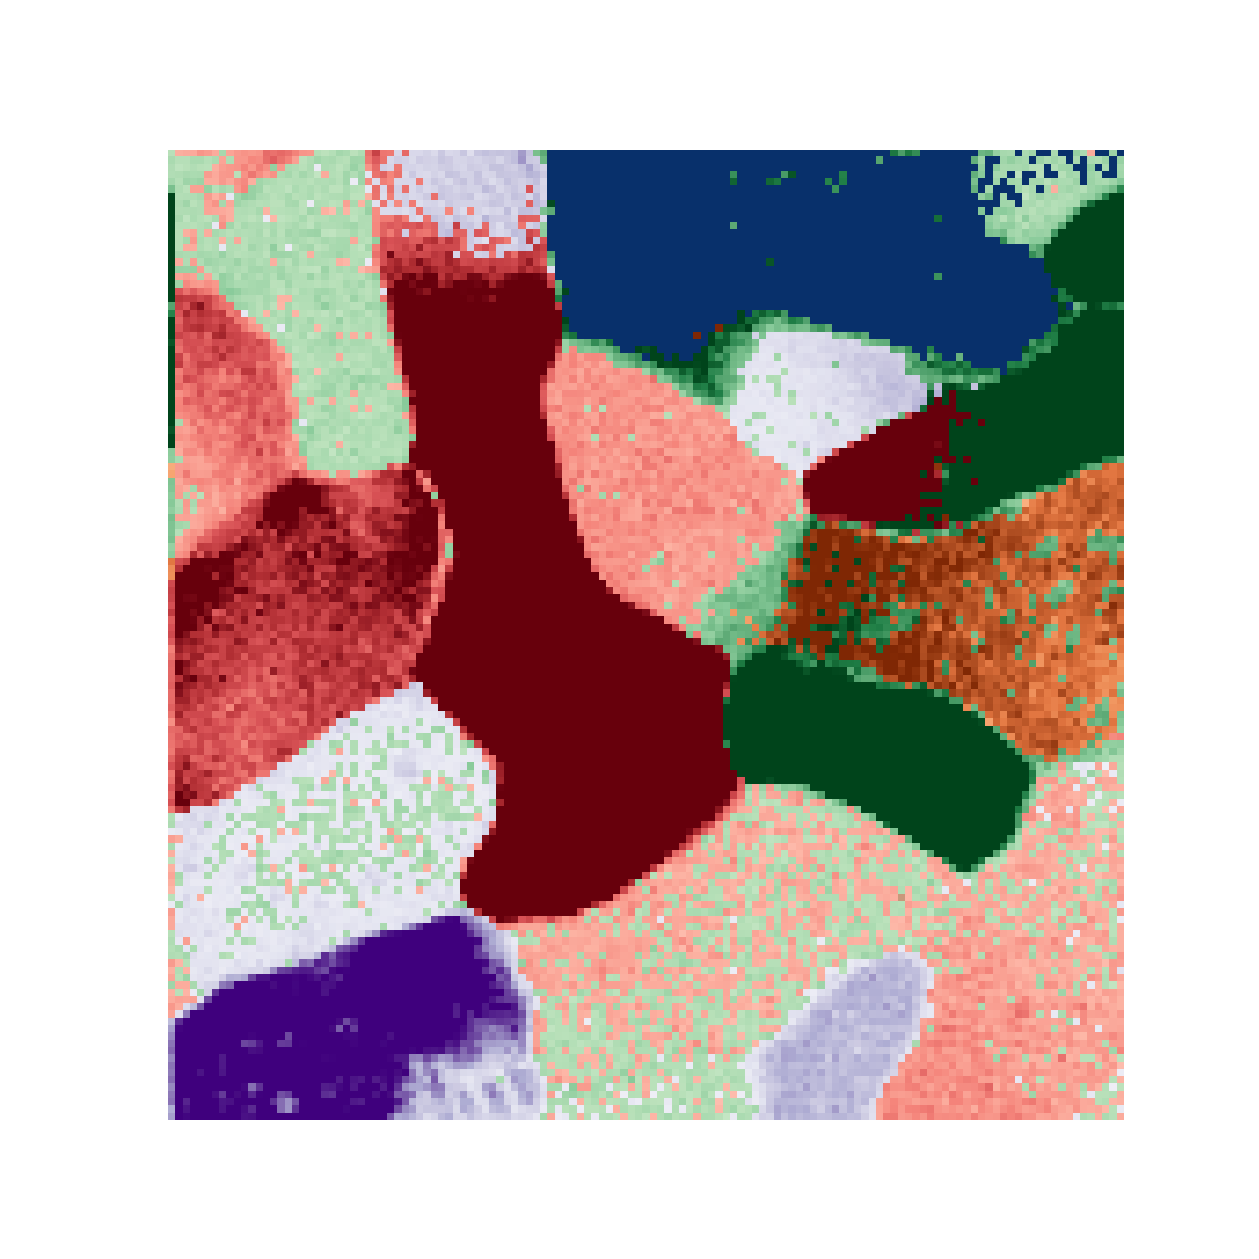

In [27]:
from matplotlib.colors import ListedColormap

new_output=output
for i in range(0,datacube.data.shape[0]):
        for j in range(0,datacube.data.shape[1]): 
            if new_output[0][i,j] >= new_output[1][i,j] and new_output[0][i,j] >= new_output[2][i,j] \
            and new_output[0][i,j] >= new_output[3][i,j] and new_output[0][i,j] >= new_output[4][i,j]:
                new_output[1][i,j]=0
                new_output[2][i,j]=0
                new_output[3][i,j]=0
                new_output[4][i,j]=0
            if new_output[1][i,j] > new_output[0][i,j] and new_output[1][i,j] > new_output[2][i,j] \
            and new_output[1][i,j] > new_output[3][i,j] and new_output[1][i,j] > new_output[4][i,j]:
                new_output[0][i,j]=0
                new_output[2][i,j]=0
                new_output[3][i,j]=0
                new_output[4][i,j]=0
            if new_output[2][i,j] > new_output[1][i,j] and new_output[2][i,j] > new_output[0][i,j] \
            and new_output[2][i,j] > new_output[3][i,j] and new_output[2][i,j] > new_output[4][i,j]:
                new_output[1][i,j]=0
                new_output[0][i,j]=0
                new_output[3][i,j]=0
                new_output[4][i,j]=0
            if new_output[3][i,j] > new_output[1][i,j] and new_output[3][i,j] > new_output[2][i,j] \
            and new_output[3][i,j] > new_output[0][i,j] and new_output[3][i,j] > new_output[4][i,j]:
                new_output[1][i,j]=0
                new_output[2][i,j]=0
                new_output[0][i,j]=0
                new_output[4][i,j]=0
            if new_output[4][i,j] > new_output[1][i,j] and new_output[4][i,j] > new_output[2][i,j] \
            and new_output[4][i,j] > new_output[0][i,j] and new_output[4][i,j] > new_output[0][i,j]:
                new_output[1][i,j]=0
                new_output[2][i,j]=0
                new_output[3][i,j]=0
                new_output[0][i,j]=0
#make your own color bars with transparent instead of white as lower bound                
cmap = plt.cm.Reds
my_red = cmap(np.arange(cmap.N))
my_red[:,-1] = np.linspace(0, 1, cmap.N)
my_red = ListedColormap(my_red)

cmap = plt.cm.Greens
my_green = cmap(np.arange(cmap.N))
my_green[:,-1] = np.linspace(0, 1, cmap.N)
my_green= ListedColormap(my_green)

cmap = plt.cm.Blues
my_blue = cmap(np.arange(cmap.N))
my_blue[:,-1] = np.linspace(0, 1, cmap.N)
my_blue = ListedColormap(my_blue)

cmap = plt.cm.Purples
my_purple = cmap(np.arange(cmap.N))
my_purple[:,-1] = np.linspace(0, 1, cmap.N)
my_purple = ListedColormap(my_purple)

cmap = plt.cm.Oranges
my_orange = cmap(np.arange(cmap.N))
my_orange[:,-1] = np.linspace(0, 1, cmap.N)
my_orange = ListedColormap(my_orange)


#@Paul, if you adjust the "vmax" values you will change the contrast of each color to make the grains glow
#Below is an example
#in general you can also add a "vmin" term but in this case, it will just lead to white space

fig,axs = plt.subplots(figsize=(7,7))
axs.matshow(new_output[0], cmap = my_blue, vmax=30000)
axs.matshow(new_output[1], cmap = my_green, vmax=200000)
axs.matshow(new_output[2], cmap = my_red, vmax=200000)
axs.matshow(new_output[3], cmap = my_purple, vmax=300000)
axs.matshow(new_output[4], cmap = my_orange, vmax=200000)

axs.axis('off')
plt.show()

fig.savefig('grain.png')

/Users/sribet/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:32: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


<IPython.core.display.Javascript object>


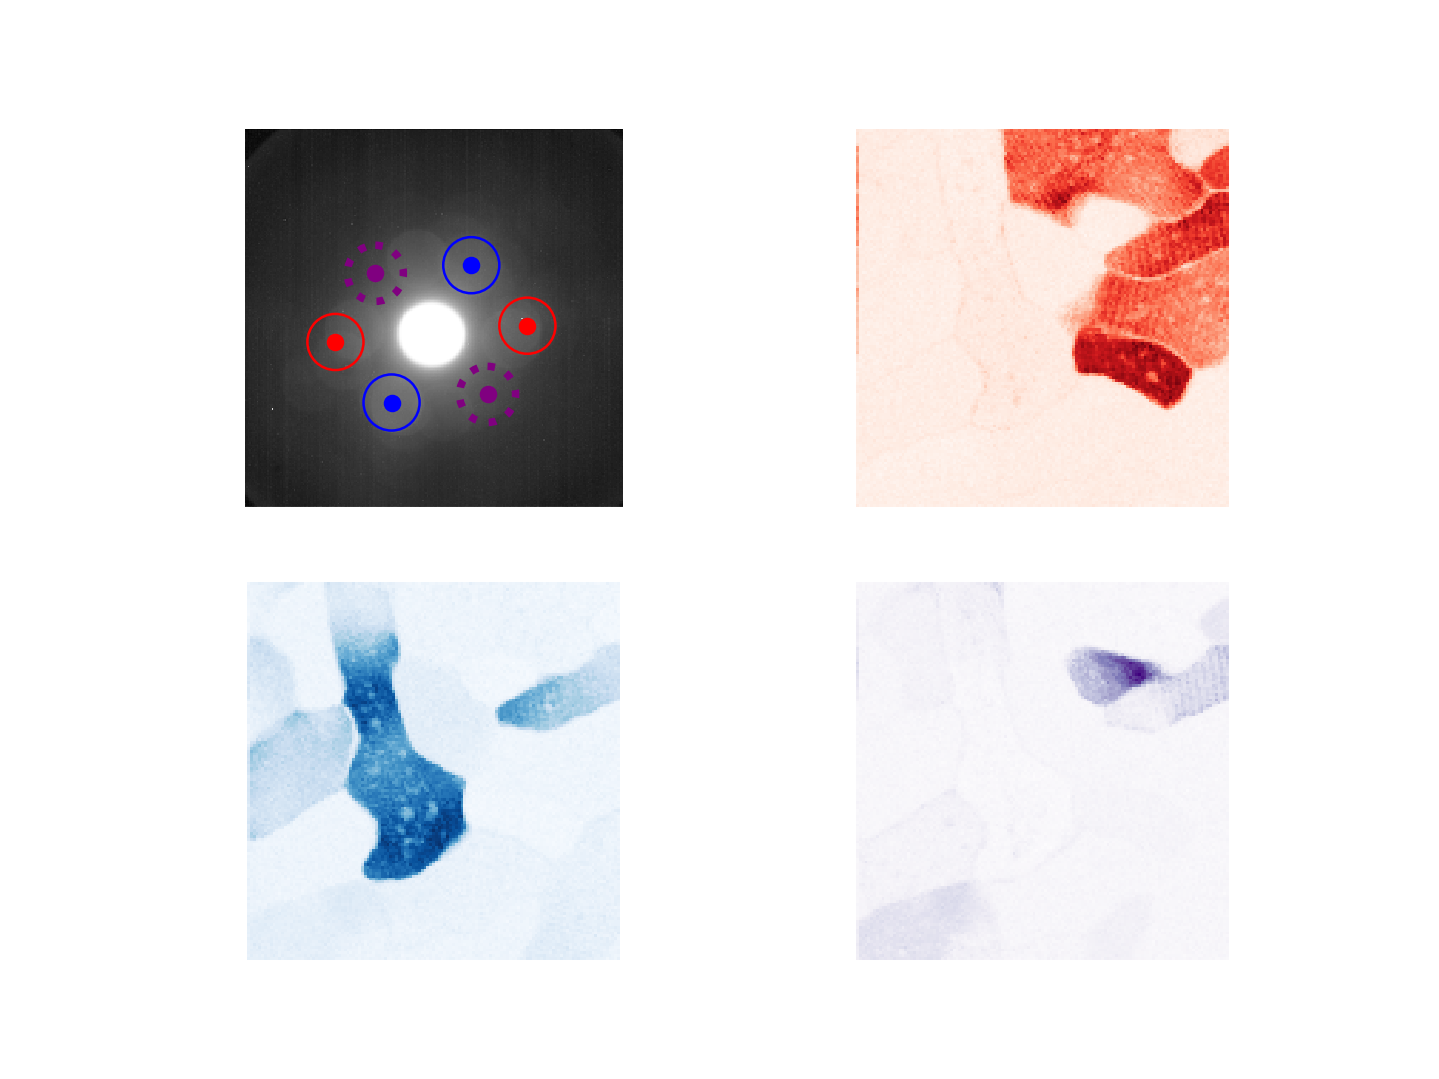

In [65]:
#vector addition, vector a and b (0-5)
a=2
b=4

#find points from adding of vectors

#two versions - one vector addition one vector subtraction
#addition_x= (-cx[a]+cx[b]+jc)
#addition_y=(-cy[a]+cy[b]+ic)
addition_x= (cx[a]+cx[b]-jc)
addition_y=(cy[a]+cy[b]-ic)
addition_x_2=-addition_x+jc*2
addition_y_2=-addition_y+ic*2

#integrae from summed vectors
x, y = np.indices((aveDP.shape[0], aveDP.shape[1]))
mask_circle1 = (x - addition_y) ** 2 + (y - addition_x) ** 2 < 20 ** 2
mask_circle2 = (x - addition_y_2) ** 2 + (y - addition_x_2) ** 2 < 20 ** 2
combine_mask = np.logical_or(mask_circle1, mask_circle2)
    
DF_real_space=np.zeros((datacube.data.shape[0],datacube.data.shape[1]))

for i in range(0,aveDP.shape[0]):
    for j in range(0,aveDP.shape[1]): 
            if combine_mask[i,j]: 
                DF_real_space=DF_real_space+datacube.data[:,:,i,j] 

combined_output=DF_real_space


#plot results
fig,axs = plt.subplots(2,2,figsize=(8,6))

axs[0,0].matshow(np.sqrt(aveDP), cmap = plt.cm.gray)

circ1 = Circle((cx[a],cy[a]),19,fill=False,color='b')
axs[0,0].scatter(cx[a],cy[a],color='b')
axs[0,0].add_patch(circ1)
circ1 = Circle((cx_2[a],cy_2[a]),19,fill=False,color='b')
axs[0,0].scatter(cx_2[a],cy_2[a],color='b')
axs[0,0].add_patch(circ1)


circ1 = Circle((cx[b],cy[b]),19,fill=False,color='red')
axs[0,0].scatter(cx[b],cy[b],color='red')
axs[0,0].add_patch(circ1)
circ1 = Circle((cx_2[b],cy_2[b]),19,fill=False,color='red')
axs[0,0].scatter(cx_2[b],cy_2[b],color='red')
axs[0,0].add_patch(circ1)


circ1 = Circle((addition_x,addition_y),19,fill=False,color='purple',ls=':', lw=3)
axs[0,0].scatter(addition_x,addition_y,color='purple')
axs[0,0].add_patch(circ1)
circ1 = Circle((addition_x_2,addition_y_2),19,fill=False,color='purple', ls=':', lw=3)
axs[0,0].scatter(addition_x_2,addition_y_2,color='purple')
axs[0,0].add_patch(circ1)


axs[1,0].matshow(output[a], cmap = plt.cm.Blues)
axs[0,1].matshow(output[b], cmap = plt.cm.Reds)
axs[1,1].matshow(combined_output, cmap = plt.cm.Purples)


axs[0,0].axis('off')
axs[1,0].axis('off')
axs[0,1].axis('off')
axs[1,1].axis('off')

plt.show()

In [29]:
#get real space image
realimage=np.average(datacube.data, axis=(2,3))

In [30]:
#integrate a specific grain area

#edit here only! x and y selected with cursor do not match x and y integration
xreal=86
yreal=22
radius=5

#integrae from summed vectors
x, y = np.indices((realimage.shape[0], realimage.shape[1]))
mask_circle1 = (yreal-x) ** 2 + (xreal-y) ** 2 < radius ** 2
    
DP=np.zeros((datacube.data.shape[2],datacube.data.shape[3]))

for i in range(0,realimage.shape[0]):
    for j in range(0,realimage.shape[1]): 
            if mask_circle1[i,j]: 
                DP=DP+datacube.data[i,j,:,:] 


<IPython.core.display.Javascript object>


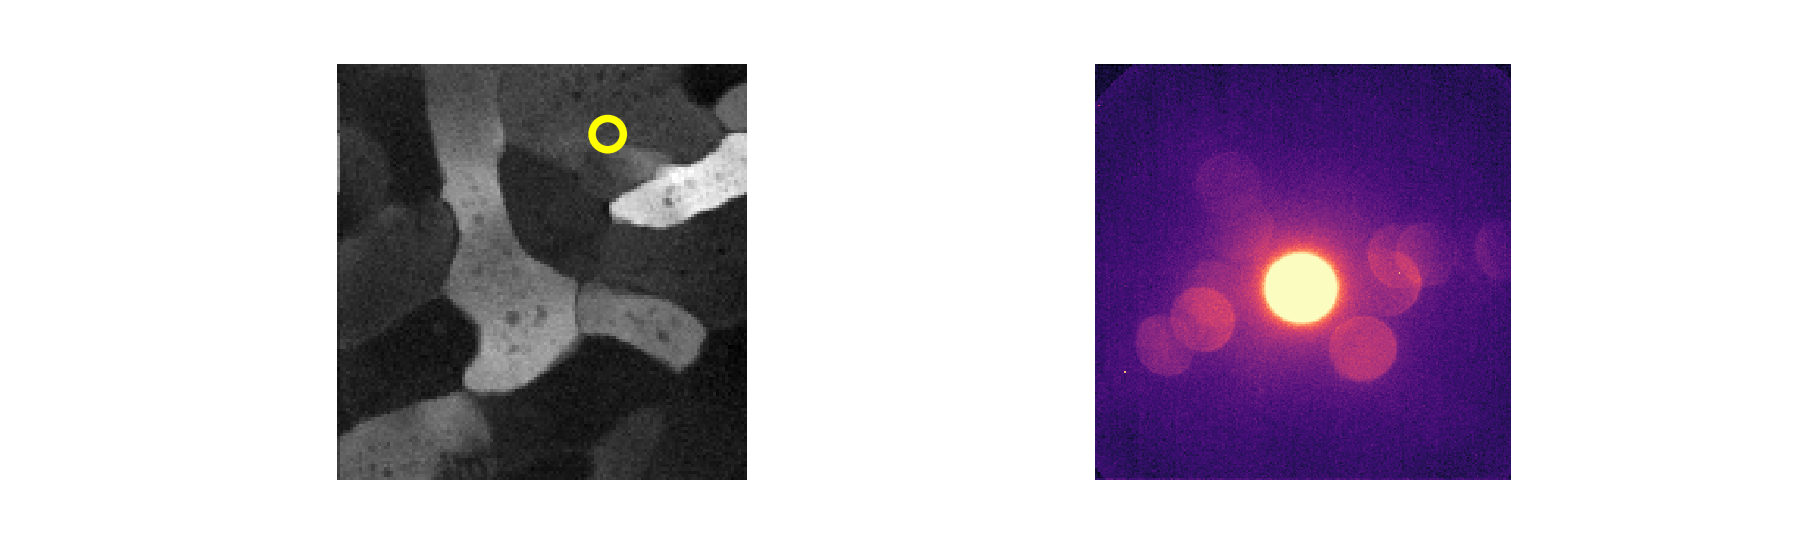

In [31]:
fig,axs = plt.subplots(1,2,figsize=(10,3))

axs[0].matshow(np.sqrt(realimage), cmap = plt.cm.gray)
axs[1].matshow(np.sqrt(DP), cmap = plt.cm.magma)
#axs[0].matshow(mask_circle1)


circ = Circle((xreal,yreal),radius,fill=False,color='yellow',lw=3)
axs[0].add_patch(circ)

axs[0].axis('off')
axs[1].axis('off')

plt.show()



<IPython.core.display.Javascript object>


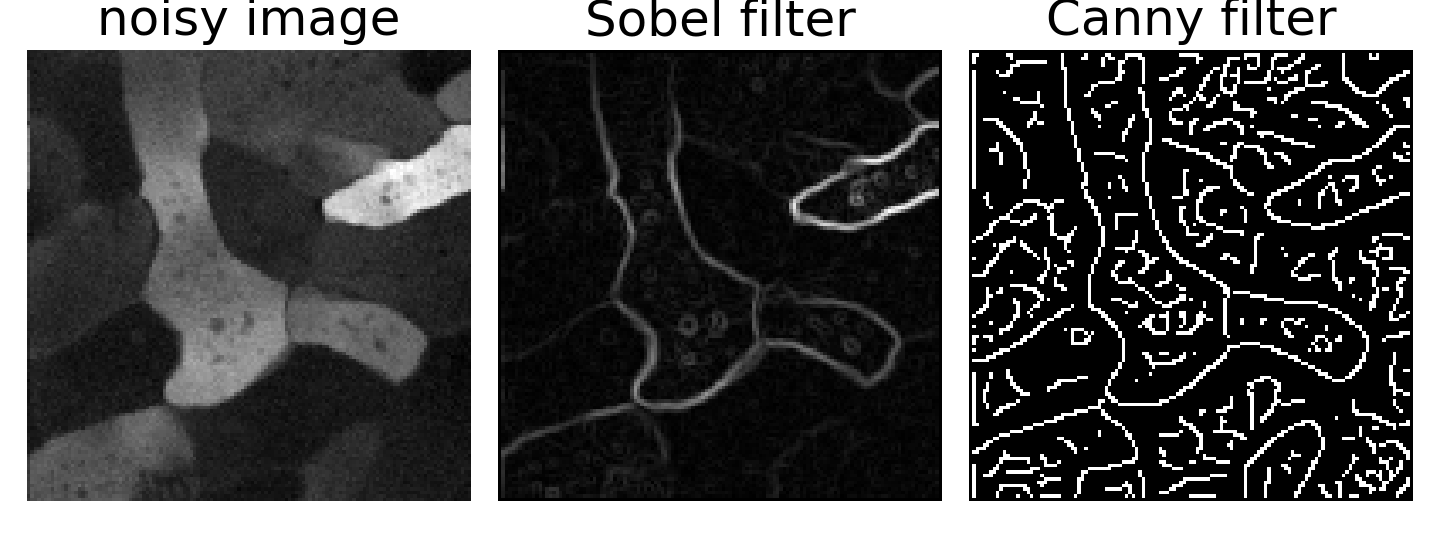

In [32]:
#filter real space image 
from skimage import filters

edges1 = filters.sobel(realimage)
edges2 = canny(realimage, sigma=2)

# display results
fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, figsize=(8, 3),
                                    sharex=True, sharey=True)

ax1.imshow(realimage, cmap=plt.cm.gray)
ax1.axis('off')
ax1.set_title('noisy image', fontsize=20)

ax2.imshow(edges1, cmap=plt.cm.gray)
ax2.axis('off')
ax2.set_title(r'Sobel filter', fontsize=20)

ax3.imshow(edges2, cmap=plt.cm.gray)
ax3.axis('off')
ax3.set_title(r'Canny filter', fontsize=20)

fig.tight_layout()

plt.show()

[ 66  74  99 113 191]
[156 136 185  86 133]


<IPython.core.display.Javascript object>


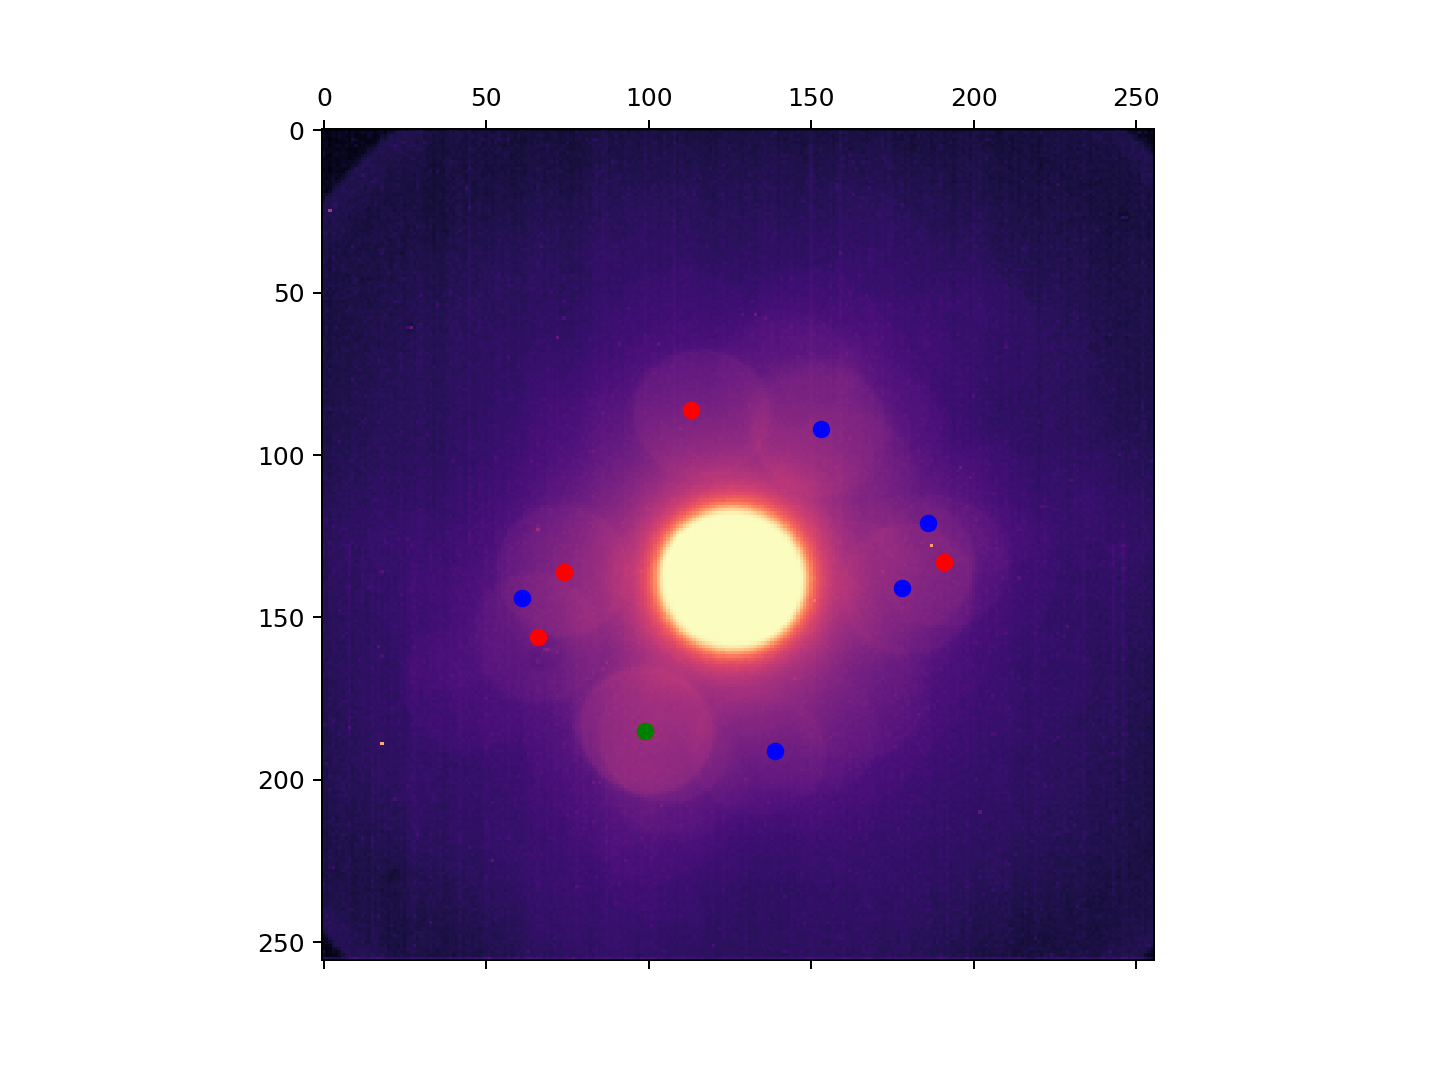

In [33]:
print(cx)
print(cy)

cx_2=-cx+jc*2
cy_2=-cy+ic*2


fig,ax = plt.subplots(figsize=(8,6))
ax.matshow(np.sqrt(aveDP), cmap = plt.cm.magma)
ax.scatter(cx_2,cy_2, color='b')
ax.scatter(cx,cy, color='r')
ax.scatter(cx[2],cy[2], color='g') #let's use this point as our starting poitn for our 6 fold mask
plt.show()

/Users/sribet/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


<IPython.core.display.Javascript object>


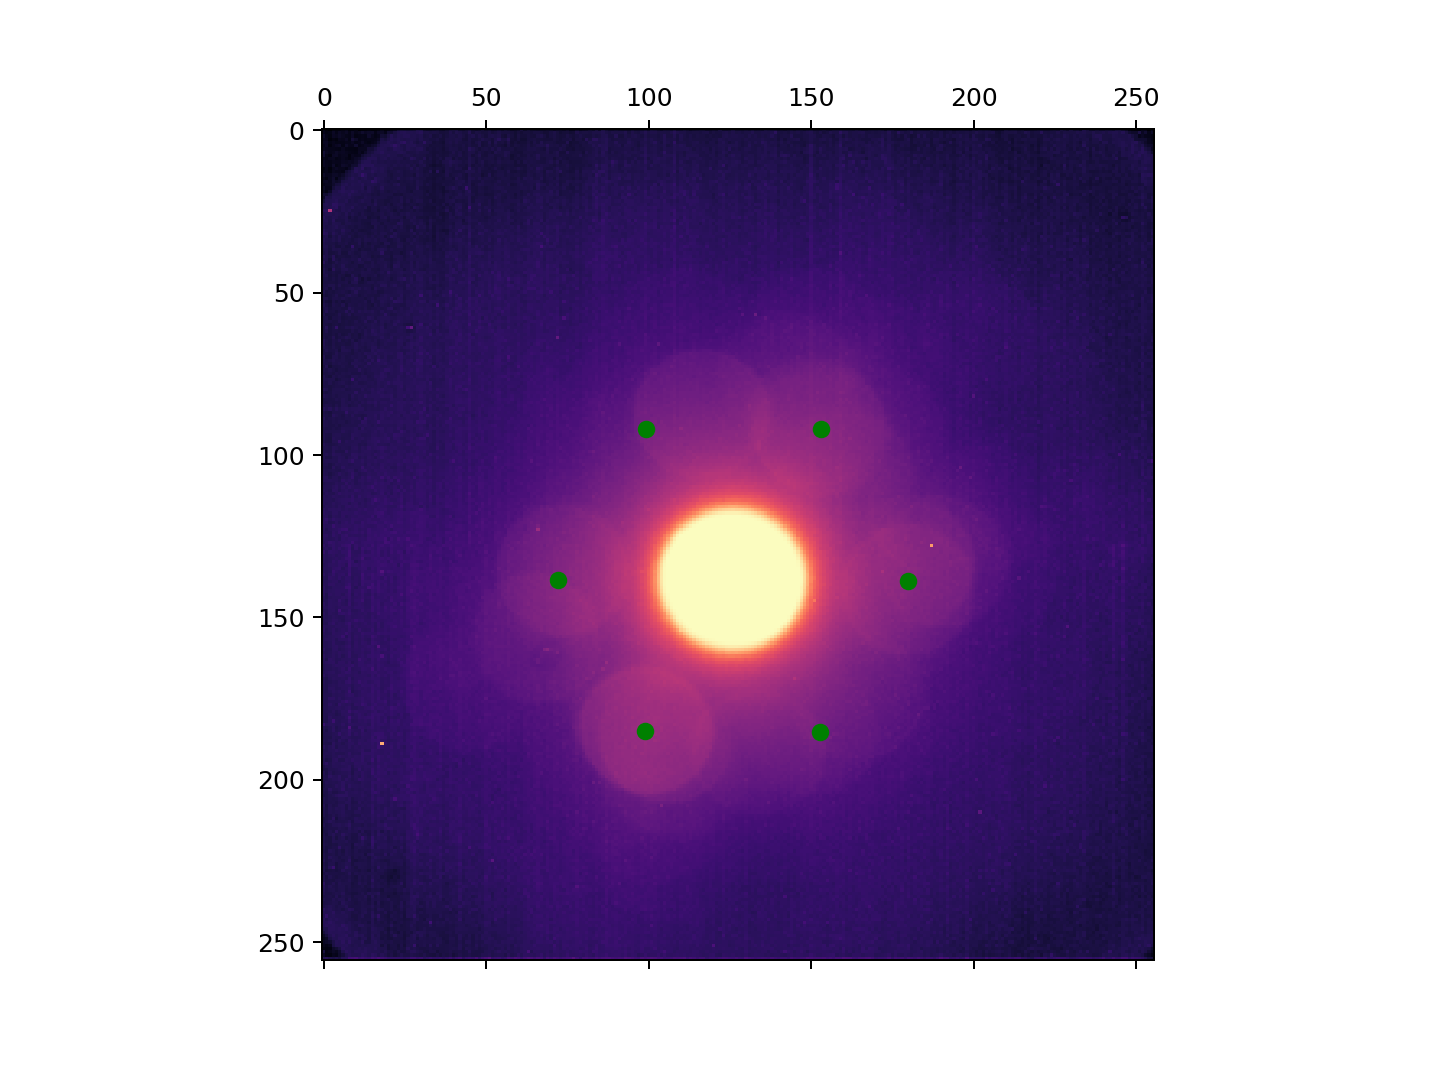

The vector length of this diffraction pattern in pixels is 53.77034498680476


In [66]:
#let's make a 6 fold mask 
theta = np.radians(60)
c, s = np.cos(theta), np.sin(theta)
R = np.array(((c, -s), (s, c)))
#print(R)
v=np.array([[cx[2]-jc],[cy[2]-ic]])
#print(v)

six_mask_x=np.zeros((1,6))
six_mask_y=np.zeros((1,6))

six_mask_x[0,0]=cx[2]
six_mask_y[0,0]=cy[2]

v_new=np.zeros((2,1))
for i in range(1,6):
    v=np.dot(v.T,R).T
    six_mask_x[0,i]=v[0,0]+jc
    six_mask_y[0,i]=v[1,0]+ic

fig,ax = plt.subplots(figsize=(8,6))
ax.matshow(np.sqrt(aveDP), cmap = plt.cm.magma)
ax.scatter(six_mask_x, six_mask_y, color='g')
plt.show()

=np.sqrt((cx[2]-jc)**2+(cy[2]-ic)**2)
print('The vector length of this diffraction pattern in pixels is ' + str(pixel_rad))

/Users/sribet/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


<IPython.core.display.Javascript object>


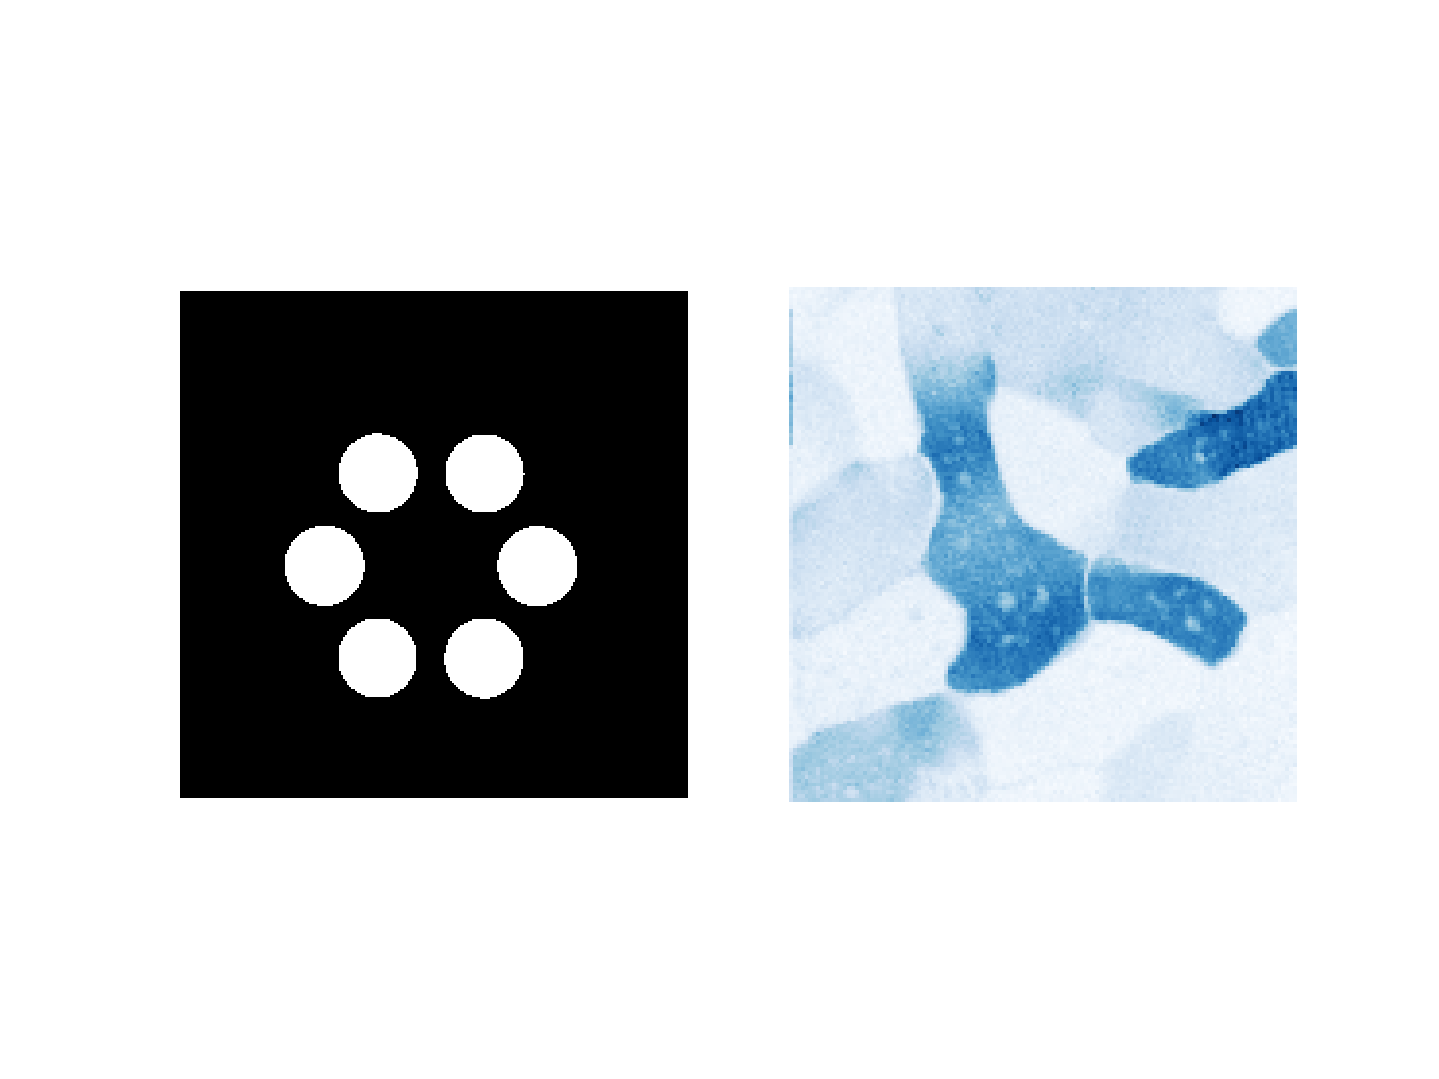

In [35]:
#Integrate first 6 fold mask 

x, y = np.indices((aveDP.shape[0], aveDP.shape[1]))
mask_circle1 = (x - six_mask_y[0,0]) ** 2 + (y- six_mask_x[0,0]) ** 2 < 20 ** 2
mask_circle2 = (x - six_mask_y[0,1]) ** 2 + (y- six_mask_x[0,1]) ** 2 < 20 ** 2
mask_circle3 = (x - six_mask_y[0,2]) ** 2 + (y- six_mask_x[0,2]) ** 2 < 20 ** 2
mask_circle4 = (x - six_mask_y[0,3]) ** 2 + (y- six_mask_x[0,3]) ** 2 < 20 ** 2
mask_circle5 = (x - six_mask_y[0,4]) ** 2 + (y- six_mask_x[0,4]) ** 2 < 20 ** 2
mask_circle6 = (x - six_mask_y[0,5]) ** 2 + (y- six_mask_x[0,5]) ** 2 < 20 ** 2
combine_mask = np.logical_or(np.logical_or(np.logical_or(mask_circle1, mask_circle2), \
                    np.logical_or(mask_circle3, mask_circle4)), np.logical_or(mask_circle5, mask_circle6))



DF_real_space=np.zeros((datacube.data.shape[0],datacube.data.shape[1]))

for i in range(0,aveDP.shape[0]-1):
    for j in range(0,aveDP.shape[1]-1): 
        if combine_mask[i,j]: 
            DF_real_space=DF_real_space+datacube.data[:,:,i,j] 

fig,axs = plt.subplots(1,2,figsize=(8,6))
axs[0].imshow(combine_mask)
axs[1].imshow(DF_real_space, cmap=plt.cm.Blues)

axs[0].axis('off')
axs[1].axis('off')

plt.show()

/Users/sribet/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


<IPython.core.display.Javascript object>


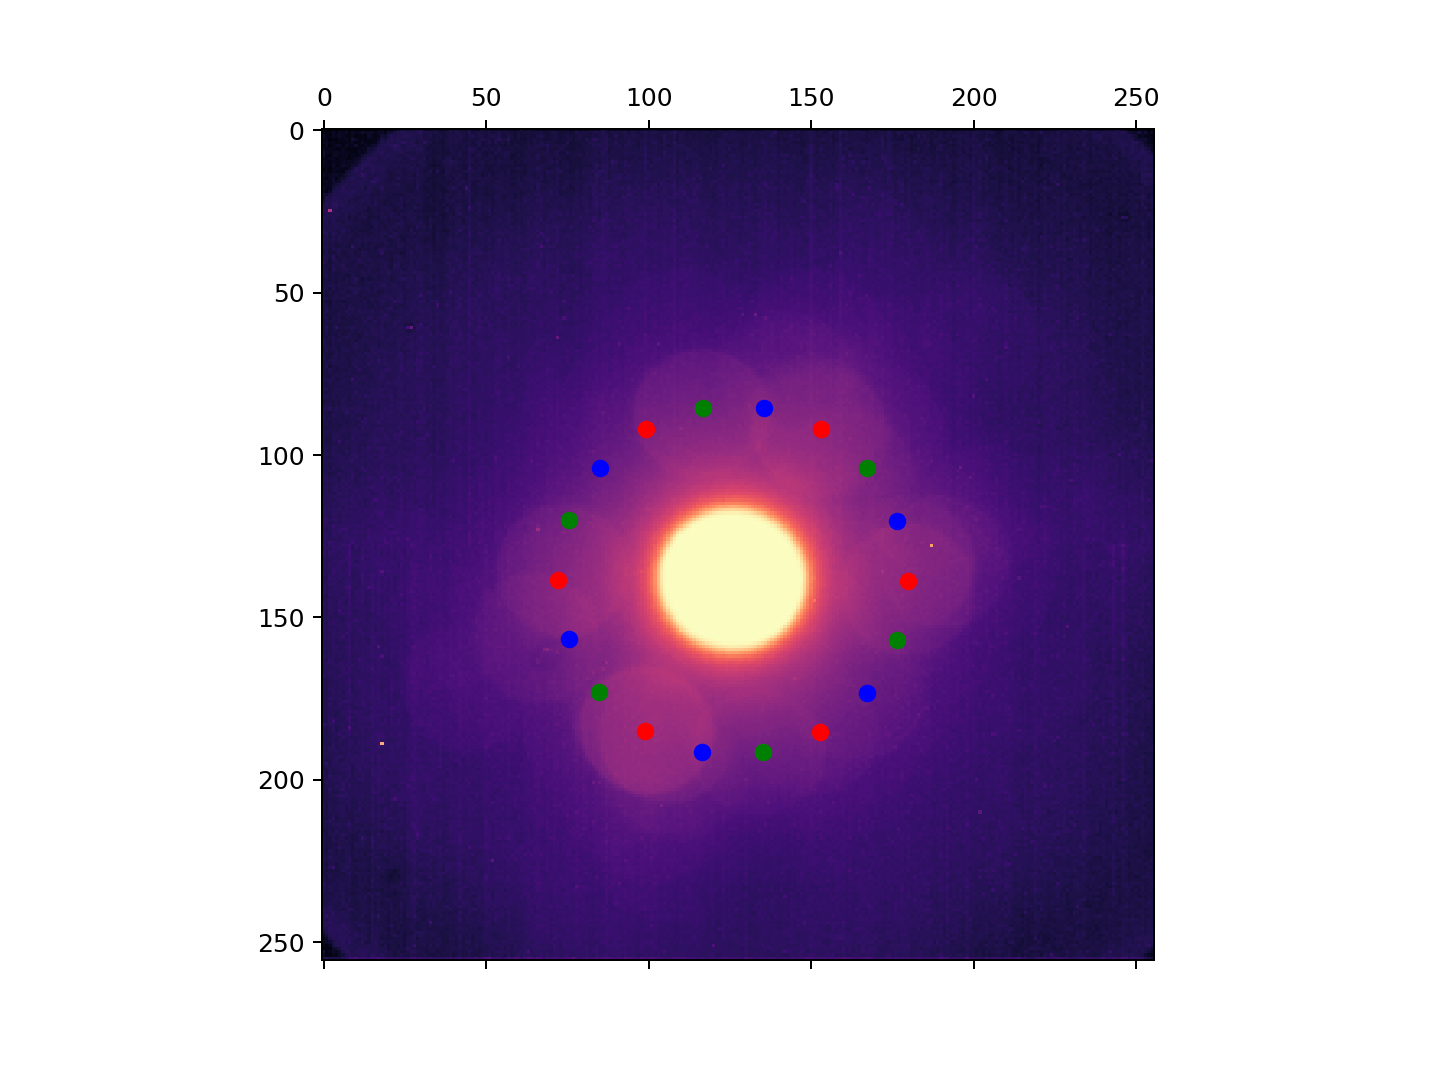

In [36]:
#starting with the initial 6 fold mask, let's rotate it by 20 and 40 degrees to check for rotation 

theta = np.radians(20)
c, s = np.cos(theta), np.sin(theta)
R = np.array(((c, -s), (s, c)))

six_rot_x=np.zeros((2,6))
six_rot_y=np.zeros((2,6))

six_rot_x=np.concatenate((six_mask_x, six_rot_x), axis=0)
six_rot_y=np.concatenate((six_mask_y, six_rot_y), axis=0)


for j in range(6):
    v=np.array([[six_rot_x[0,j]-jc],[six_rot_y[0,j]-ic]])
    for i in range(1,3):
        v=np.dot(v.T,R).T
        six_rot_x[i,j]=v[0,0]+jc
        six_rot_y[i,j]=v[1,0]+ic

fig,ax = plt.subplots(figsize=(8,6))
ax.matshow(np.sqrt(aveDP), cmap = plt.cm.magma)
ax.scatter(six_rot_x[0], six_rot_y[0], color='r')
ax.scatter(six_rot_x[1], six_rot_y[1], color='b')
ax.scatter(six_rot_x[2], six_rot_y[2], color='g')
plt.show()



In [37]:
#Integrate first 6 fold mask 

output=[]
masks=[]
rad=16
x, y = np.indices((aveDP.shape[0], aveDP.shape[1]))
for k in range(3):
    mask_circle1 = (x - six_rot_y[k,0]) ** 2 + (y- six_rot_x[k,0]) ** 2 < rad ** 2
    mask_circle2 = (x - six_rot_y[k,1]) ** 2 + (y- six_rot_x[k,1]) ** 2 < rad ** 2
    mask_circle3 = (x - six_rot_y[k,2]) ** 2 + (y- six_rot_x[k,2]) ** 2 < rad ** 2
    mask_circle4 = (x - six_rot_y[k,3]) ** 2 + (y- six_rot_x[k,3]) ** 2 < rad ** 2
    mask_circle5 = (x - six_rot_y[k,4]) ** 2 + (y- six_rot_x[k,4]) ** 2 < rad ** 2
    mask_circle6 = (x - six_rot_y[k,5]) ** 2 + (y- six_rot_x[k,5]) ** 2 < rad ** 2
    combine_mask = np.logical_or(np.logical_or(np.logical_or(mask_circle1, mask_circle2), \
                    np.logical_or(mask_circle3, mask_circle4)), np.logical_or(mask_circle5, mask_circle6))

    masks.append(combine_mask)
    DF_real_space=np.zeros((datacube.data.shape[0],datacube.data.shape[1]))
    for i in range(0,aveDP.shape[0]):
        for j in range(0,aveDP.shape[1]): 
            if combine_mask[i,j]: 
                DF_real_space=DF_real_space+datacube.data[:,:,i,j] 
    output.append(DF_real_space)

/Users/sribet/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  This is separate from the ipykernel package so we can avoid doing imports until


<IPython.core.display.Javascript object>


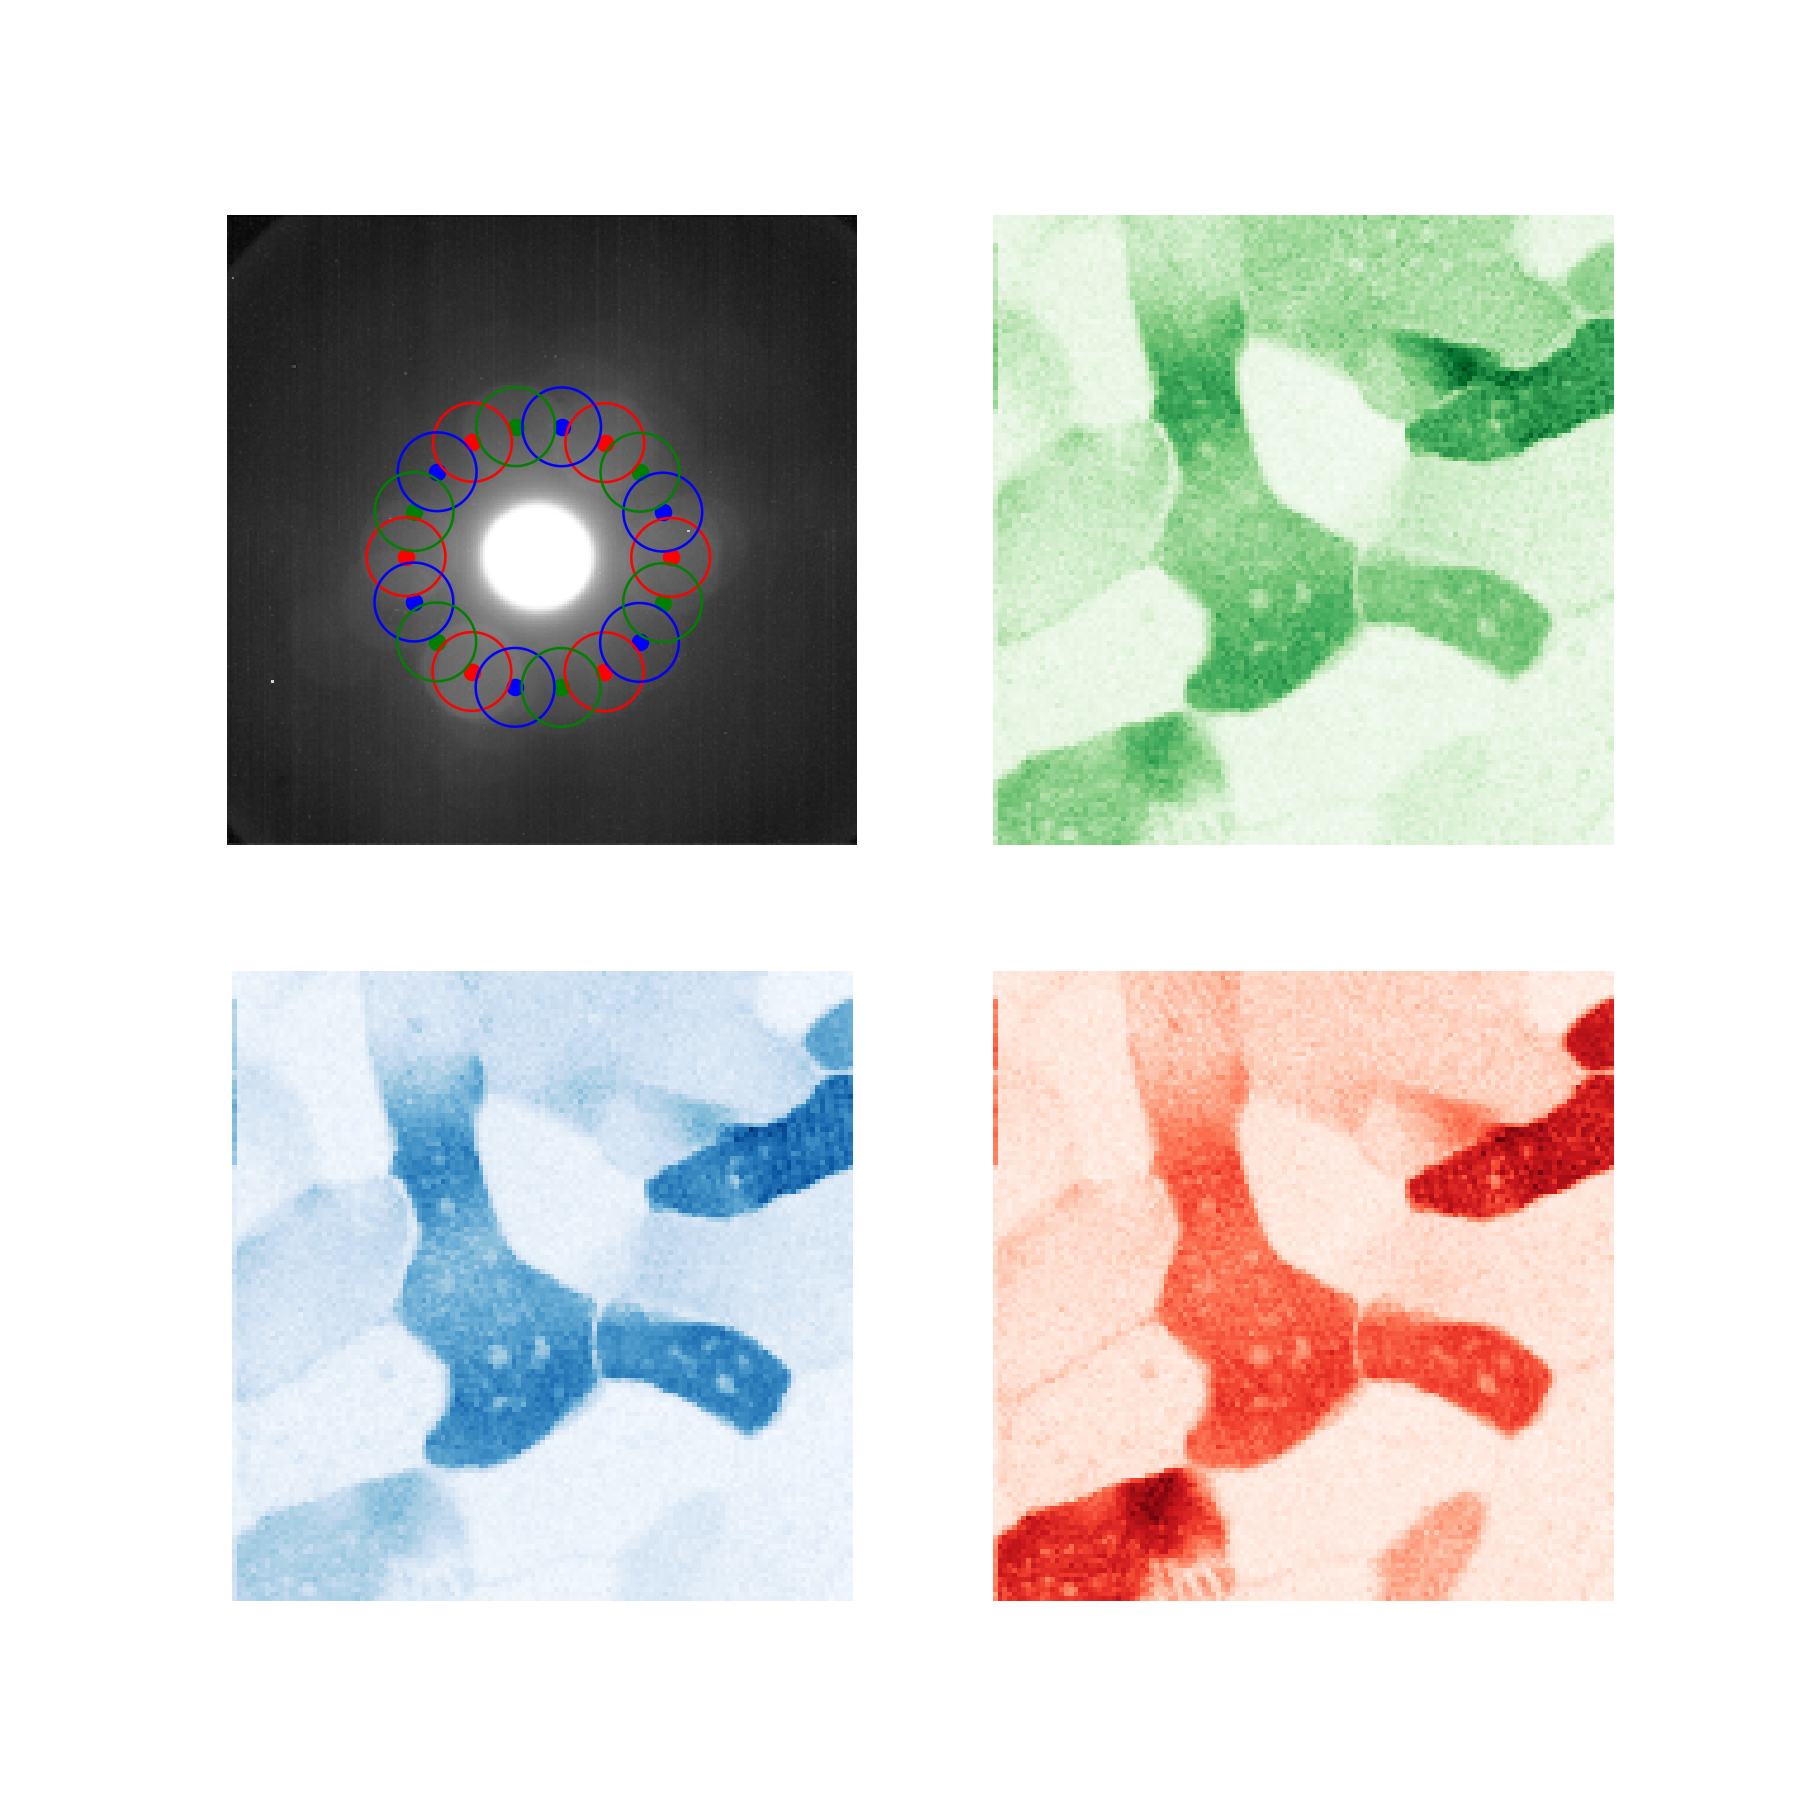

In [38]:
aveDP = np.average(datacube.data, axis=(0,1))

fig,axs = plt.subplots(2, 2, figsize=(10,10))

axs[0,0].matshow(np.sqrt(aveDP), cmap = plt.cm.gray)

axs[0,0].scatter(six_rot_x[0], six_rot_y[0], color='r')
for i in range(6):
    circ1 = Circle((six_rot_x[0,i],six_rot_y[0,i]),rad,fill=False,color='red')
    axs[0,0].add_patch(circ1)

axs[0,0].scatter(six_rot_x[1], six_rot_y[1], color='b')
for i in range(6):
    circ1 = Circle((six_rot_x[1,i],six_rot_y[1,i]),rad,fill=False,color='blue')
    axs[0,0].add_patch(circ1)
    
axs[0,0].scatter(six_rot_x[2], six_rot_y[2], color='g')
for i in range(6):
    circ1 = Circle((six_rot_x[2,i],six_rot_y[2,i]),rad,fill=False,color='green')
    axs[0,0].add_patch(circ1)


axs[1,0].matshow(output[0], cmap = plt.cm.Blues)
axs[0,1].matshow(output[1], cmap = plt.cm.Greens)
axs[1,1].matshow(output[2], cmap = plt.cm.Reds)



axs[0,0].axis('off')
axs[1,0].axis('off')
axs[0,1].axis('off')
axs[1,1].axis('off')


plt.show()

/Users/sribet/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  del sys.path[0]


<IPython.core.display.Javascript object>


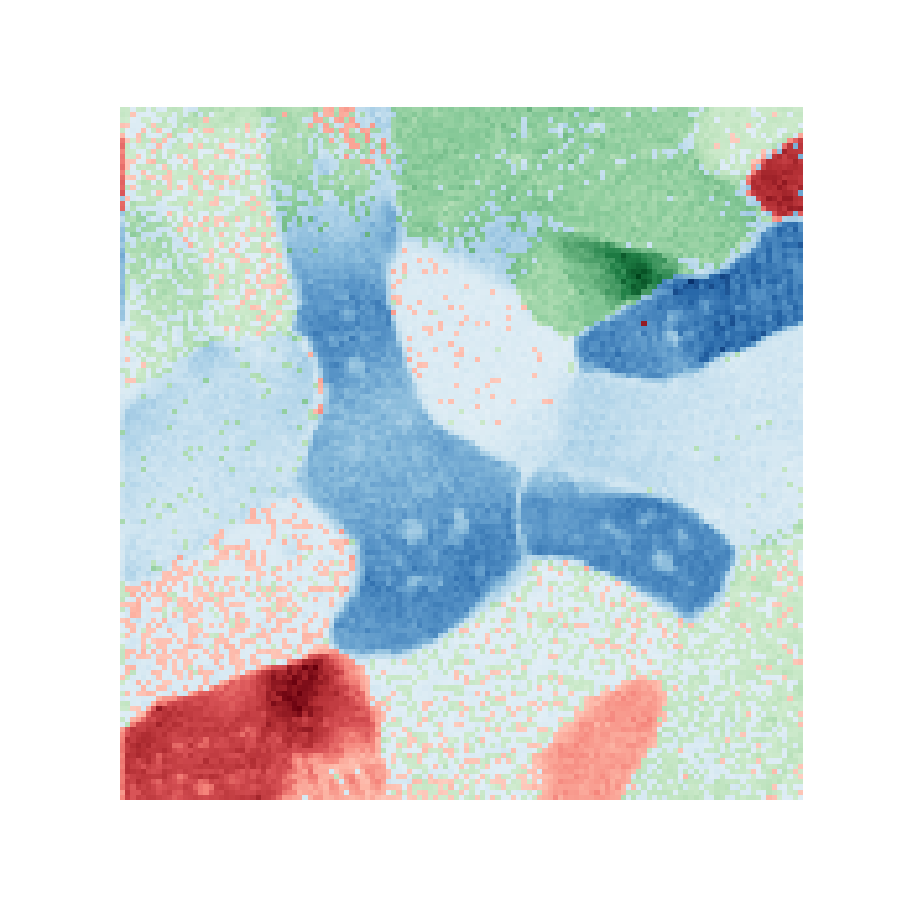

In [39]:
for i in range(0,datacube.data.shape[0]):
        for j in range(0,datacube.data.shape[1]): 
            if output[0][i,j] >= output[1][i,j] and output[0][i,j] >= output[2][i,j]:
                output[1][i,j]=0
                output[2][i,j]=0
            if output[1][i,j] > output[0][i,j] and output[1][i,j] > output[2][i,j]:
                output[0][i,j]=0
                output[2][i,j]=0
            if output[2][i,j] > output[1][i,j] and output[2][i,j] > output[0][i,j]:
                output[0][i,j]=0
                output[1][i,j]=0

fig,axs = plt.subplots(figsize=(5,5))
axs.matshow(output[0], cmap = my_blue)
axs.matshow(output[1], cmap = my_green)
axs.matshow(output[2], cmap = my_red)

axs.axis('off')

plt.show()

/Users/sribet/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  # This is added back by InteractiveShellApp.init_path()


<IPython.core.display.Javascript object>


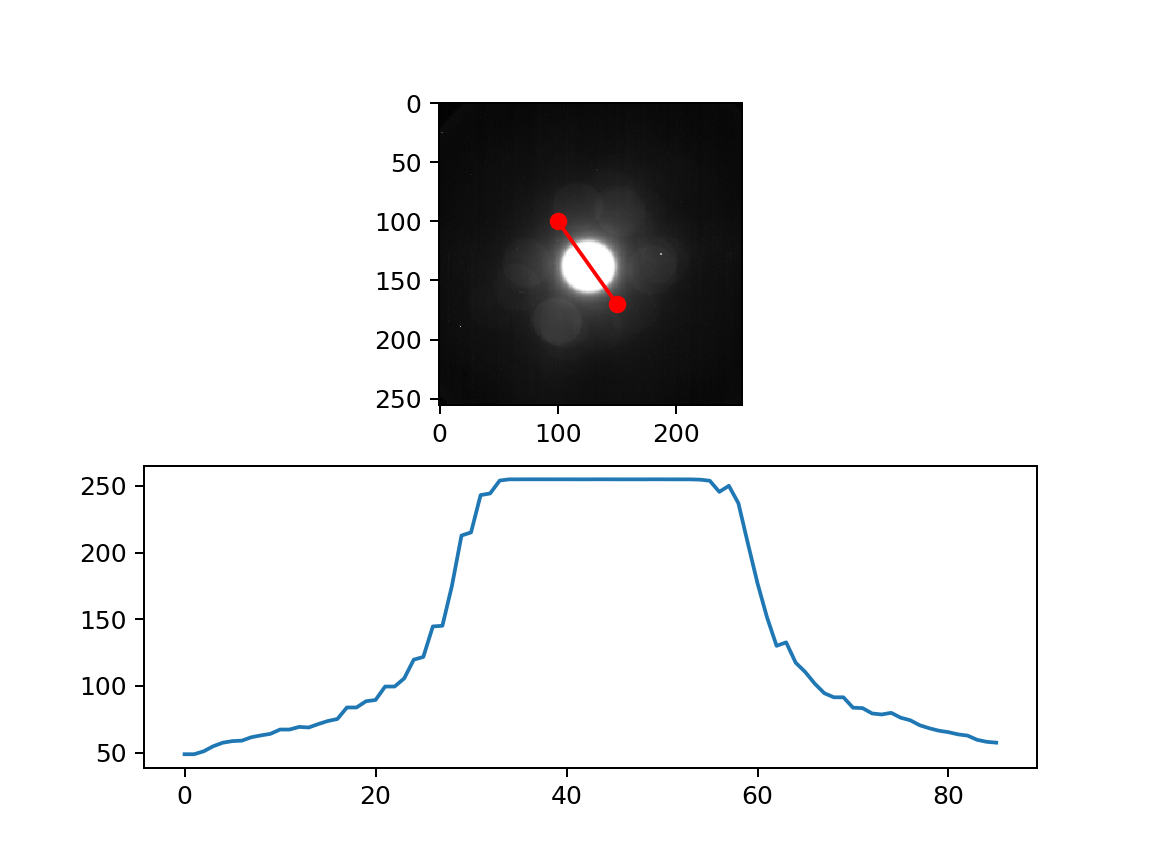

In [72]:
# Make a line with "num" points...
x0, y0 = 100, 100 # These are in _pixel_ coordinates!!
x1, y1 = 150, 170
length = int(np.hypot(x1-x0, y1-y0))
x, y = np.linspace(x0, x1, length), np.linspace(y0, y1, length)

# Extract the values along the line
zi = aveDP[x.astype(np.int), y.astype(np.int)]

#-- Plot...
fig, axes = plt.subplots(nrows=2)
axes[0].imshow(aveDP)
axes[0].plot([x0, x1], [y0, y1], 'ro-')
axes[0].axis('image')

axes[1].plot(zi)

plt.show()

/Users/sribet/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


<IPython.core.display.Javascript object>


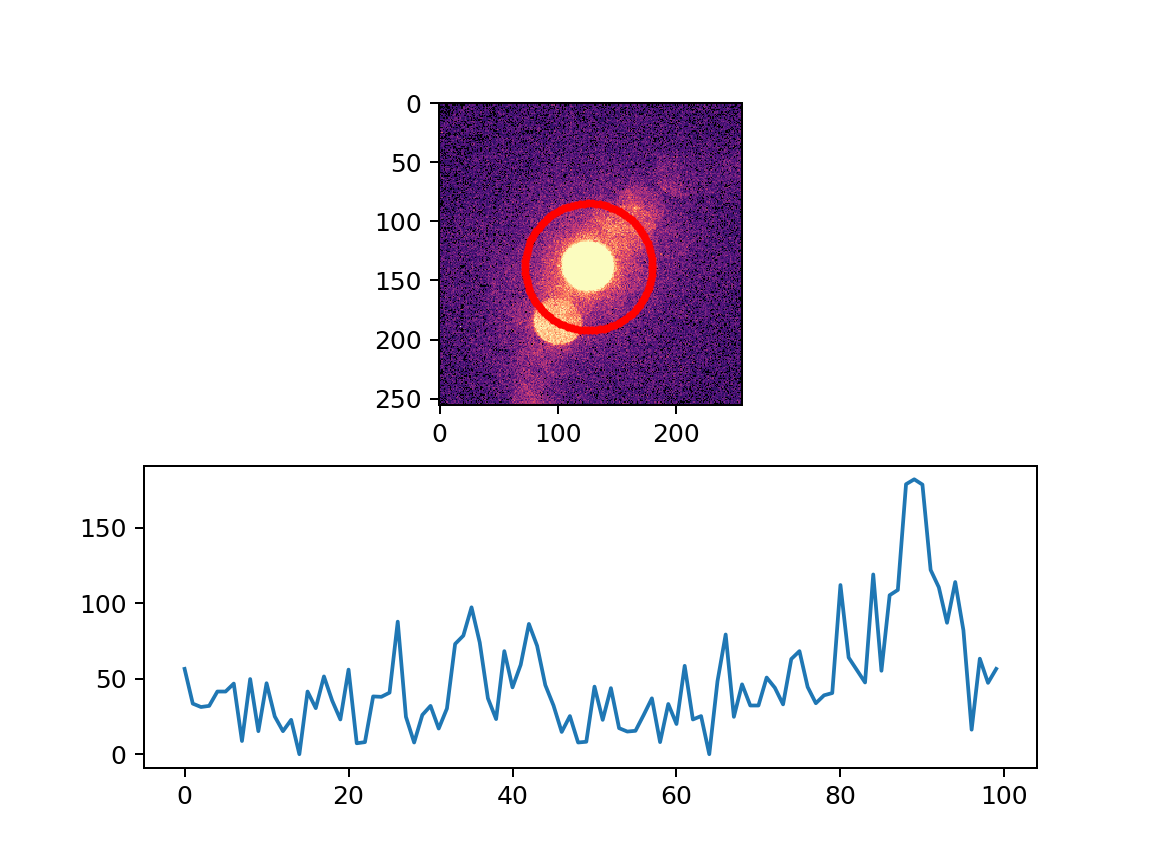

In [91]:
image=np.average(datacube.data[50:52,50:52,:,:], axis=(0,1))

n_dots = 100   # set number of dots
angs = np.linspace(0, 2*np.pi, n_dots)  # angles to the dots
cx, cy = (jc, ic)  # center of circle
xs, ys = [], []    # for coordinates of points to plot
ra = pixel_rad          # radius of circle

for ang in angs:
    # compute (x,y) for each point
    x = cx + ra*np.cos(ang)
    y = cy + ra*np.sin(ang)
    xs.append(x)   # collect x
    ys.append(y)   # collect y

xs=np.asarray(xs)
ys=np.asarray(ys)

zi = image[xs.astype(np.int), ys.astype(np.int)]

fig, axes = plt.subplots(nrows=2)

axes[0].scatter(xs, ys, c = 'red', s=5)  # plot points 
axes[0].imshow(np.sqrt(image), cmap= plt.cm.magma)

axes[1].plot(zi)

plt.show()


In [78]:
type(xs)

numpy.ndarray